change output to binary list to a single float value, which will be the sum of the target outputs.

In [26]:
import torch
import torch.nn as nn
import math
import pandas as pd
from datetime import datetime as dt, timedelta
from torch.utils.data import Dataset, DataLoader
import os
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import numpy as np

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# device = torch.device('cpu')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 42  # choose any seed you prefer
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)



cuda


In [27]:
# hyperparameters for dataset and dataloader
input_size = 20
target_size = 2
batch_size = 16

# hyperparameters for model
num_features = 1  # 입력 시퀀스의 특징 수 (예: open, close 가격)

d_model = 64
n_heads = 2
num_encoder_layers = 2
d_ff = 256
dropout_rate = 0.1
lstm_hidden_size = 64
num_lstm_layers = 2

# hyperparameters for training, testing
learning_rate = 0.01
num_epochs = 100

In [28]:
class PriceDataset(Dataset):
    def __init__(self, item, timespan, start_date_str, end_date_str, input_window_size, target_window_size):
        self.directory = f'C:/Github/DL-FinalProject/csvfiles/{item}/'
        self.input_window_size = input_window_size
        self.target_window_size = target_window_size
        self.columns = [1, 4]  # Adjust as needed for zero-based indexing in NumPy
        self.data = self.load_data(start_date_str, end_date_str)

    def load_data(self, start_date_str, end_date_str):
        start_date = dt.strptime(start_date_str, '%Y-%m-%d').date()
        end_date = dt.strptime(end_date_str, '%Y-%m-%d').date()
        all_data = []

        for filename in os.listdir(self.directory):
            # Extract date from filename
            file_date_str = '-'.join(filename.split('-')[2:]).split('.')[0]
            file_date = dt.strptime(file_date_str, '%Y-%m-%d').date()

            if start_date <= file_date <= end_date:
                file_path = os.path.join(self.directory, filename)
                # Use NumPy to read the CSV file
                data = np.loadtxt(file_path, delimiter=',', usecols=self.columns, skiprows=1)
                # print(f"Reading file: {filename}, Data shape: {data.shape}")  # Debugging print
                all_data.append(data)

        # Concatenate all data arrays
        combined_data = np.vstack(all_data)
        # print(f"Shape of the combined data: {combined_data.shape}")
        return combined_data

    def __len__(self):
        return len(self.data) - self.input_window_size - self.target_window_size + 1

    def __getitem__(self, idx):
        if idx + self.input_window_size + self.target_window_size > len(self.data):
            raise IndexError("Index out of bounds")

        window_data = self.data[idx:idx + self.input_window_size + self.target_window_size]
        open_prices = window_data[:, 0]  # Open prices column
        close_prices = window_data[:, 1]  # Close prices column
        percentage_changes = ((close_prices - open_prices) * 100 / open_prices)
        input_data = torch.tensor(percentage_changes[:self.input_window_size], dtype=torch.float32)
        target_data = torch.tensor(percentage_changes[self.input_window_size:], dtype=torch.float32)
        return idx, (input_data, target_data)

In [29]:
# 포지셔널 인코딩 클래스
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# 시계열 트랜스포머 모델 클래스
class TimeSeriesTransformerModel(nn.Module):
    def __init__(self, num_features, d_model, n_heads, num_encoder_layers, d_ff, dropout_rate, lstm_hidden_size, num_lstm_layers, target_size):
        super(TimeSeriesTransformerModel, self).__init__()
        self.d_model = d_model

        # LSTM Layer
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=lstm_hidden_size, num_layers=num_lstm_layers, batch_first=True)
        
        # Linear layer to transform LSTM output to match Transformer d_model size
        self.linear1 = nn.Linear(lstm_hidden_size, d_model)

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout_rate)
        
        # Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model, n_heads, d_ff, dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        
        self.attention_weights = nn.Parameter(torch.randn(input_size, 1))


        # Output layer
        self.out = nn.Linear(d_model, target_size)

    def forward(self, src):
        # LSTM layer
        lstm_out, _ = self.lstm(src)
        # lstm_out: [batch_size, sequence_length, lstm_hidden_size]

        # Transform LSTM output to match Transformer d_model size
        src = self.linear1(lstm_out) * math.sqrt(self.d_model)
        # src: [batch_size, sequence_length, d_model]

        # Positional Encoding and Transformer
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        # output: [batch_size, sequence_length, d_model]

        # 가중치 평균 계산을 위한 어텐션 적용
        attention_weights = torch.softmax(self.attention_weights, dim=0)
        output = torch.matmul(output.transpose(1, 2), attention_weights).squeeze(-1)
        # output: [batch_size, d_model]

        # 선형 레이어를 통과시켜 최종 출력 생성 / 시그모이드는 BCEwithLogitsLoss function에서 사용
        output = self.out(output)
        # output: [batch_size, target_size]

        output = output.sum(dim=1)

        return output

In [30]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for batch_indices, (input_data, target_data) in train_loader:
        optimizer.zero_grad()
        
        # Data dimension change and move to device
        input_data = input_data.unsqueeze(-1).to(device)  # [32, 10] -> [32, 10, 1]
        target_data = target_data.sum(dim=1).to(device)  # [32, 5]

        # Model prediction
        output = model(input_data)

        # Loss calculation and backpropagation
        loss = criterion(output, target_data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if batch_indices[0] % 100000 == 0:
            # print(f"Inside training loop. Batch indices: {batch_indices[0]}, loss value: {total_loss/batch_indices[0]}")
            print(f"Inside training loop. Batch indices: {batch_indices[0]}, loss value: {total_loss/batch_indices[0]}")

    # return total_loss
    return total_loss / len(train_loader)

def test(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_indices, (input_data, target_data) in test_loader:
            # Data dimension change and move to device
            input_data = input_data.unsqueeze(-1).to(device)  # [32, 10] -> [32, 10, 1]
            target_data = target_data.sum(dim=1).to(device)  # [32, 5]

            # Model prediction
            output = model(input_data)

            # Loss calculation
            loss = criterion(output, target_data)
            total_loss += loss.item()


            if batch_indices[0] % 100000 == 0:
                # print(f"Inside testing loop. Batch indices: {batch_indices[0]}, loss value: {total_loss/batch_indices[0]}")
                print(f"Inside testing loop. Batch indices: {batch_indices[0]}, loss value: {total_loss/batch_indices[0]}")

    # return total_loss
    return total_loss / len(test_loader)


In [31]:
# Example usage
train_dataset = PriceDataset('BTCUSDT', '1m', '2021-03-01', '2021-05-31', input_window_size=input_size, target_window_size=target_size)
test_dataset = PriceDataset('BTCUSDT', '1m', '2023-01-01', '2023-03-01', input_window_size=input_size, target_window_size=target_size)
# print(train_dataset.__len__())
# print(test_dataset.__len__())

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # 학습 데이터 로더
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)   # 테스트 데이터 로더


# 모델 인스턴스 생성
model = TimeSeriesTransformerModel(num_features, d_model, n_heads, num_encoder_layers, d_ff, dropout_rate, lstm_hidden_size, num_lstm_layers, target_size)
model = model.to(device)


# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



In [32]:
# def test_first_batches(model, data_loader, criterion, device, num_batches=20):
#     model.eval()  # Set the model to evaluation mode
#     with torch.no_grad():
#         for i, (batch_indices, (input_data, target_data)) in enumerate(data_loader):
#             if i >= num_batches:
#                 break  # Only test the first 20 batches

#             # Data dimension change and move to device
#             input_data = input_data.unsqueeze(-1).to(device)  # Reshape for the model if necessary
#             target_data = target_data.sum(dim=1).to(device)

#             # Model prediction
#             output = model(input_data)

#             # Calculate loss
#             loss = criterion(output, target_data)

#             # Print batch information
#             print(f"Batch {i + 1}/{num_batches}")
#             print(f"Input Data: {input_data}")
#             print(f"Target Data: {target_data}")
#             print(f"Output Data: {output}")
#             print(f"Loss: {loss.item()}\n")

# # Usage of the testing function
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Assuming train_dataset is defined
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)   # Assuming test_dataset is defined
# criterion = nn.BCEWithLogitsLoss()  # Assuming you are using BCEWithLogitsLoss
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Test the first 20 batches of the training data
# print("Testing on Training Data:")
# test_first_batches(model, train_loader, criterion, device)

# # Test the first 20 batches of the test data
# print("Testing on Test Data:")
# test_first_batches(model, test_loader, criterion, device)

Pre-trained model loaded.
Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015620301710441709
Inside testing loop. Batch indices: 0, loss value: inf
Model saved as 'model_input20_target2_dmodel64_nheads2_encoderlayers2_lstmhidden64_lstmlayers2.pth' at Epoch 1
Epoch 1/100, Train Loss: 0.047754690945347934, Test Loss: 0.007757548230773399


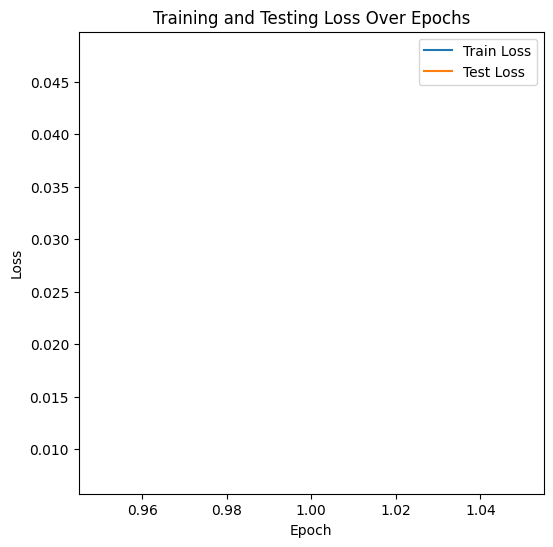

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015486233169212937
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 2/100, Train Loss: 0.04747813963736355, Test Loss: 0.00785171278287966


<Figure size 640x480 with 0 Axes>

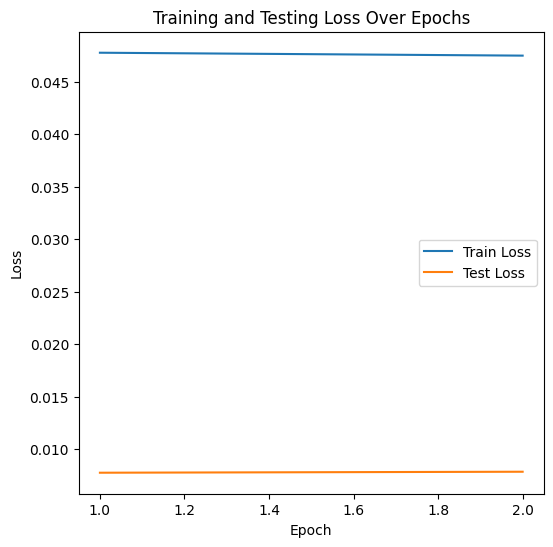

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015544400084763765
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 3/100, Train Loss: 0.04770690388023292, Test Loss: 0.007901107077076823


<Figure size 640x480 with 0 Axes>

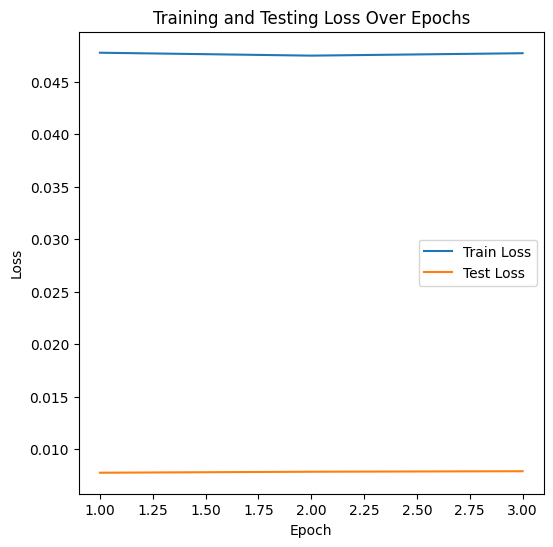

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015525142662227154
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 4/100, Train Loss: 0.04761310618530484, Test Loss: 0.00784844743970767


<Figure size 640x480 with 0 Axes>

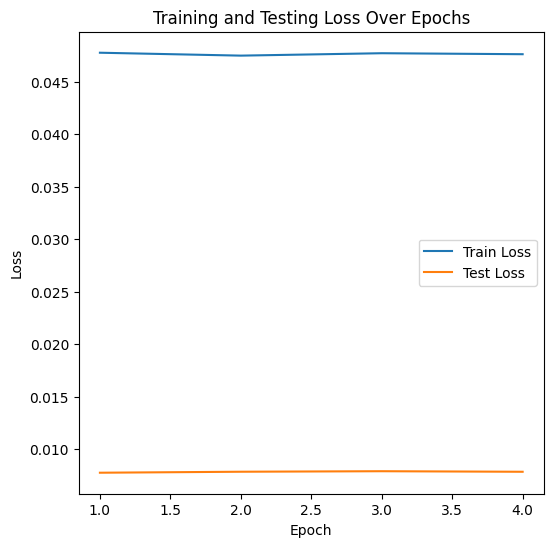

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.00155409995932132
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 5/100, Train Loss: 0.047763405635871524, Test Loss: 0.007865832692908342


<Figure size 640x480 with 0 Axes>

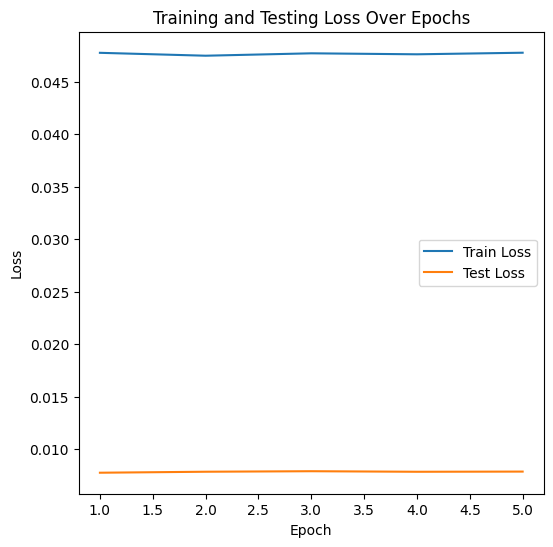

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015496270498260856
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 6/100, Train Loss: 0.04771396062427864, Test Loss: 0.007962684920453078


<Figure size 640x480 with 0 Axes>

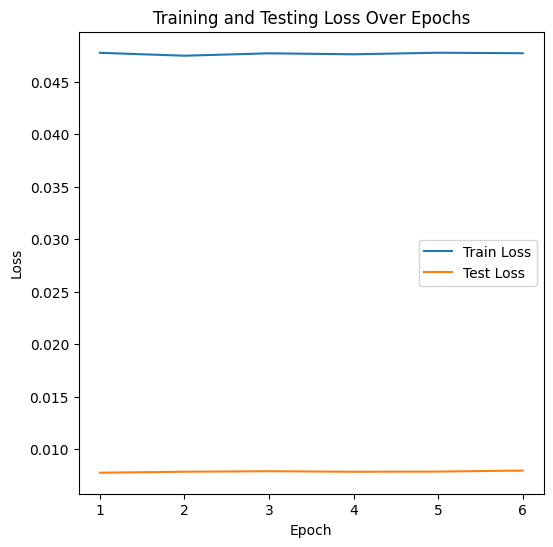

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.001548237749375403
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 7/100, Train Loss: 0.04752278396944919, Test Loss: 0.007836743196120474


<Figure size 640x480 with 0 Axes>

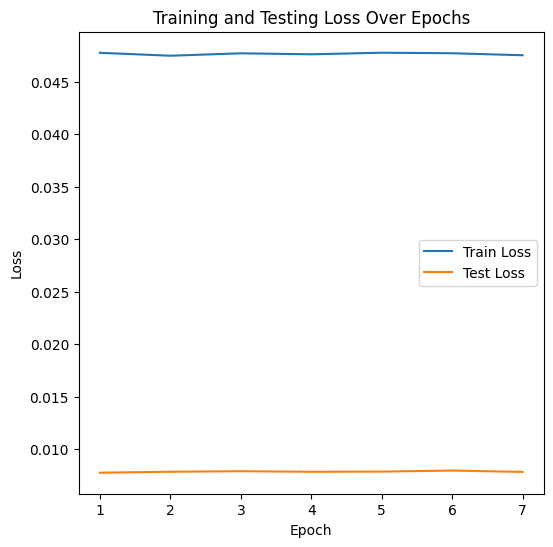

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015541429165750742
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 8/100, Train Loss: 0.04782521658655963, Test Loss: 0.007835118258702098


<Figure size 640x480 with 0 Axes>

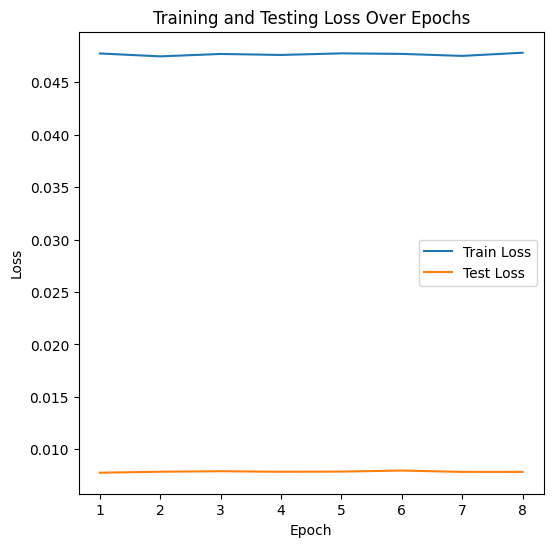

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015512933023273945
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 9/100, Train Loss: 0.04772581120348723, Test Loss: 0.007866685273564563


<Figure size 640x480 with 0 Axes>

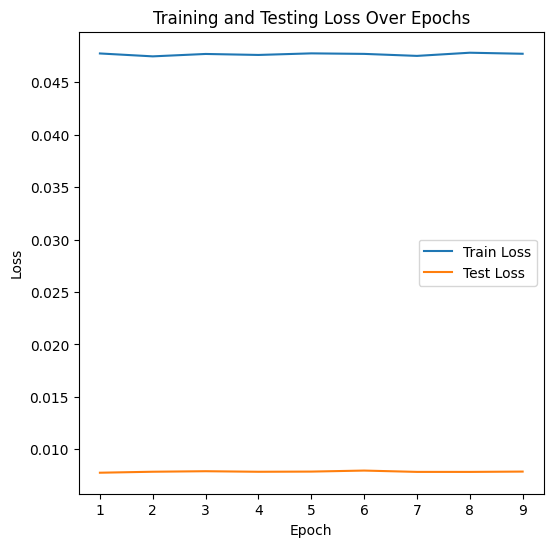

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015513881808146834
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 10/100, Train Loss: 0.04770795830085761, Test Loss: 0.007800745808942251


<Figure size 640x480 with 0 Axes>

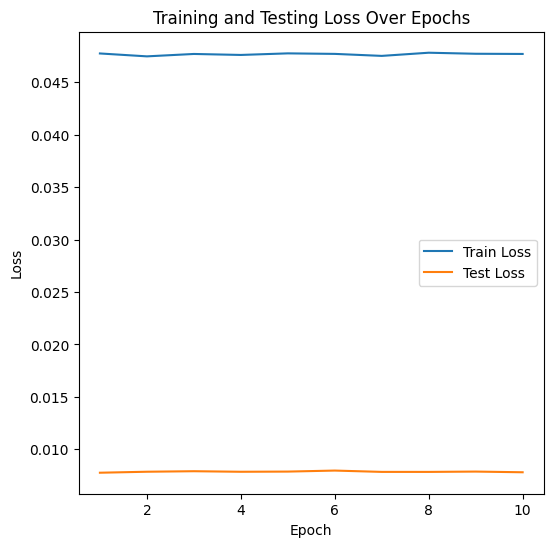

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015491889789700508
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 11/100, Train Loss: 0.04751505934022745, Test Loss: 0.00788603850526099


<Figure size 640x480 with 0 Axes>

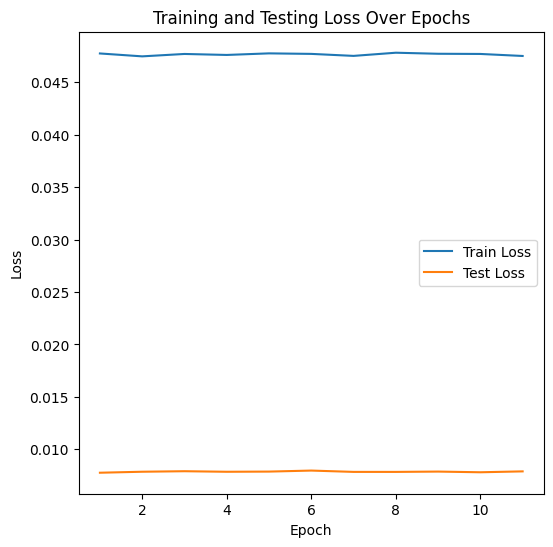

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015506127383559942
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 12/100, Train Loss: 0.04756964081242586, Test Loss: 0.007812741243166537


<Figure size 640x480 with 0 Axes>

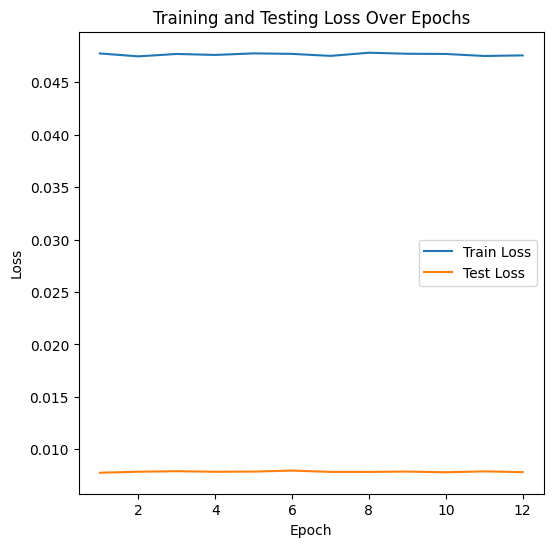

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015531888930127025
Inside testing loop. Batch indices: 0, loss value: inf
Model saved as 'model_input20_target2_dmodel64_nheads2_encoderlayers2_lstmhidden64_lstmlayers2.pth' at Epoch 13
Epoch 13/100, Train Loss: 0.04759564815385506, Test Loss: 0.007690836919380291


<Figure size 640x480 with 0 Axes>

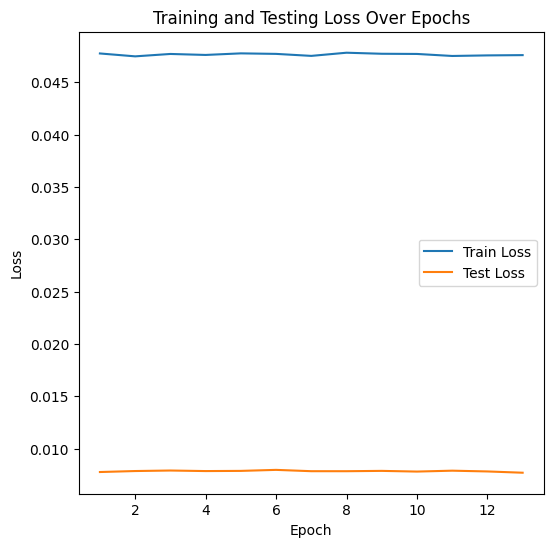

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015506292693316936
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 14/100, Train Loss: 0.04752636806124105, Test Loss: 0.007825612505952149


<Figure size 640x480 with 0 Axes>

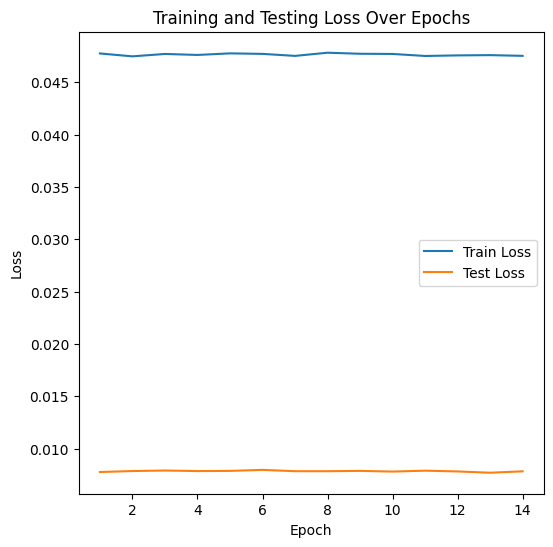

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015513277612626553
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 15/100, Train Loss: 0.047633039555551926, Test Loss: 0.007761251115079344


<Figure size 640x480 with 0 Axes>

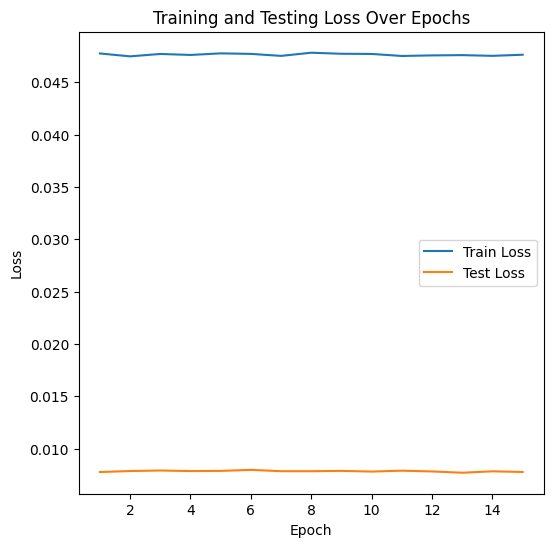

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015541160246357322
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 16/100, Train Loss: 0.04757939318775212, Test Loss: 0.00776432754785297


<Figure size 640x480 with 0 Axes>

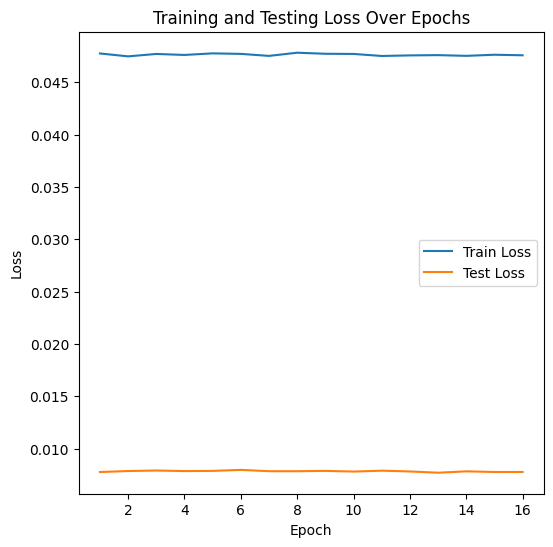

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015541869215667248
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 17/100, Train Loss: 0.04769331840227766, Test Loss: 0.007840438347101705


<Figure size 640x480 with 0 Axes>

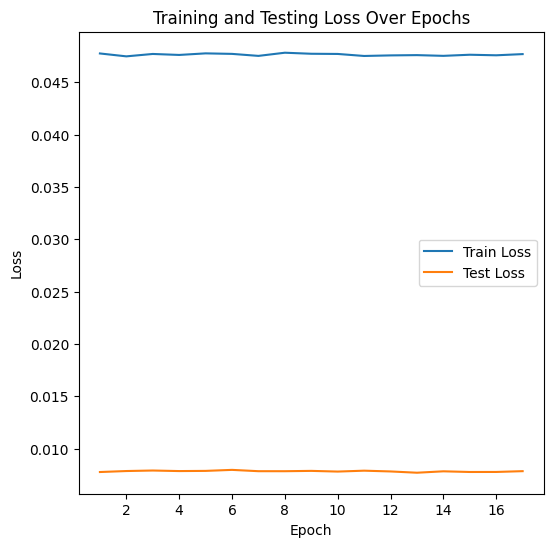

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015524557093158364
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 18/100, Train Loss: 0.04753609439802248, Test Loss: 0.007898801222907623


<Figure size 640x480 with 0 Axes>

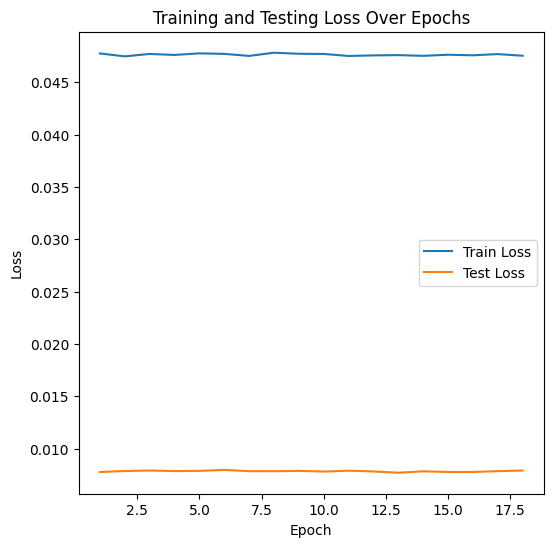

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015525051858276129
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 19/100, Train Loss: 0.04763100816721303, Test Loss: 0.0076929911300503825


<Figure size 640x480 with 0 Axes>

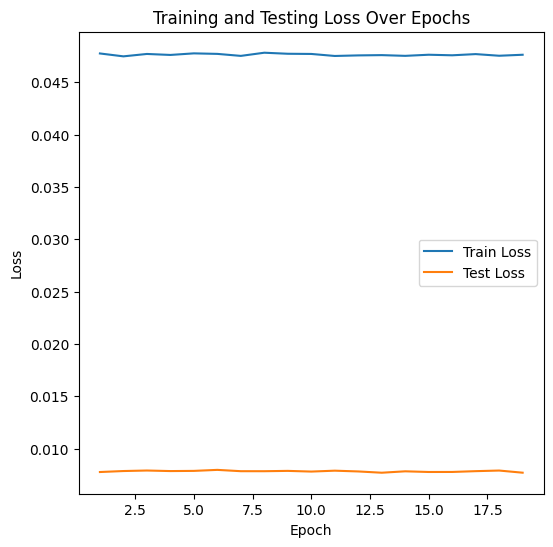

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015543111367151141
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 20/100, Train Loss: 0.04766231570534252, Test Loss: 0.007807716205912496


<Figure size 640x480 with 0 Axes>

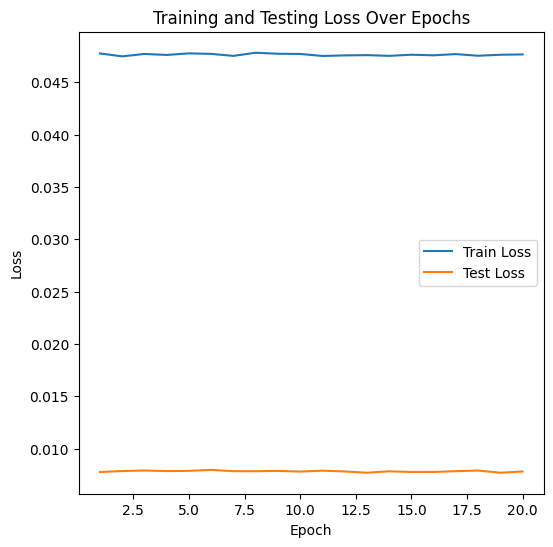

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.001553799258545041
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 21/100, Train Loss: 0.04762661599523269, Test Loss: 0.007843523950066135


<Figure size 640x480 with 0 Axes>

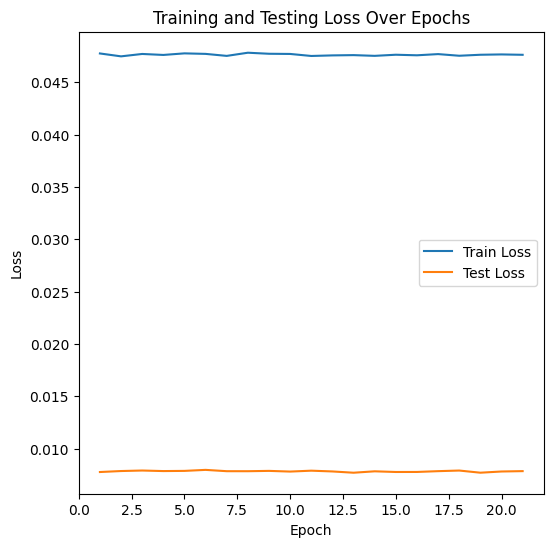

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015532003017142415
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 22/100, Train Loss: 0.047587822831295354, Test Loss: 0.007836634632521197


<Figure size 640x480 with 0 Axes>

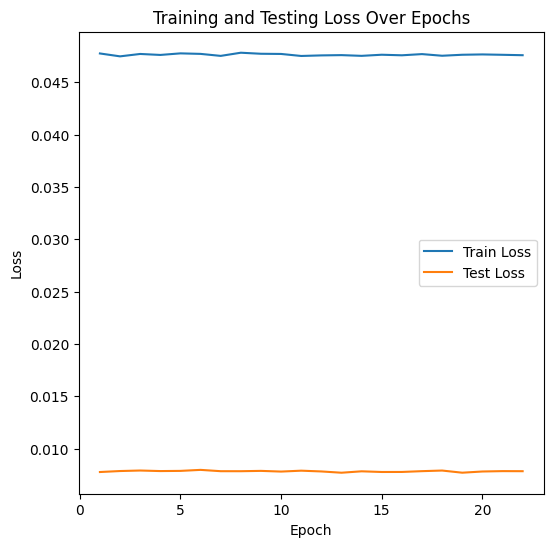

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015522583853453398
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 23/100, Train Loss: 0.047744191366683716, Test Loss: 0.007859445156540766


<Figure size 640x480 with 0 Axes>

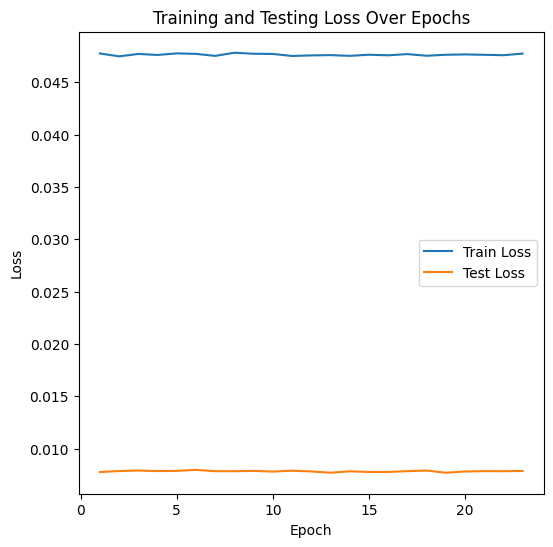

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015527303330600262
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 24/100, Train Loss: 0.04761802132064199, Test Loss: 0.007836077958571446


<Figure size 640x480 with 0 Axes>

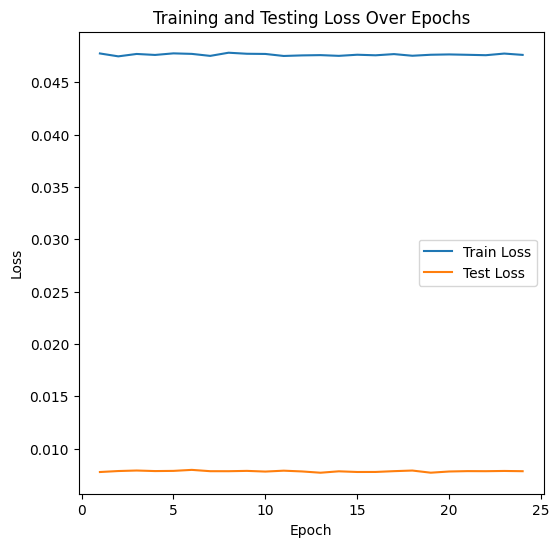

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015533862169831991
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 25/100, Train Loss: 0.047905551866354916, Test Loss: 0.007949486290799187


<Figure size 640x480 with 0 Axes>

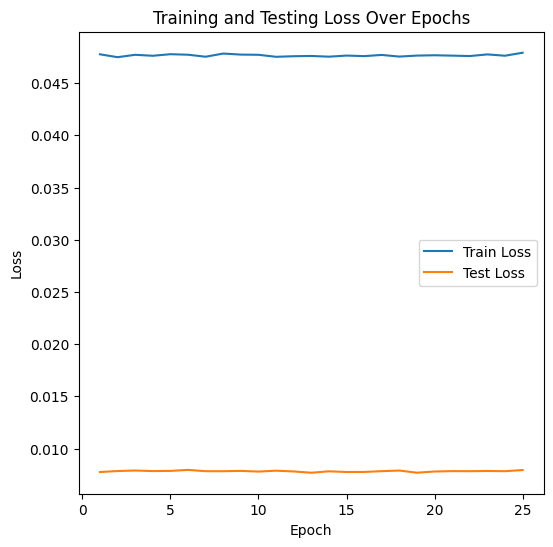

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015481822192668915
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 26/100, Train Loss: 0.047558757252125536, Test Loss: 0.007825389713284355


<Figure size 640x480 with 0 Axes>

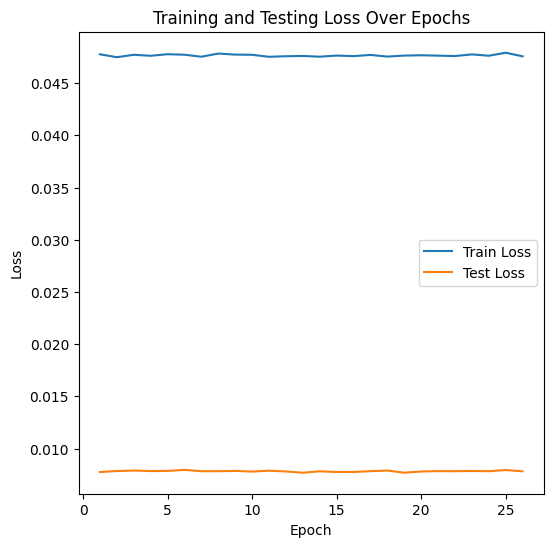

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.001550336368381977
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 27/100, Train Loss: 0.047553993295623896, Test Loss: 0.007895374360130828


<Figure size 640x480 with 0 Axes>

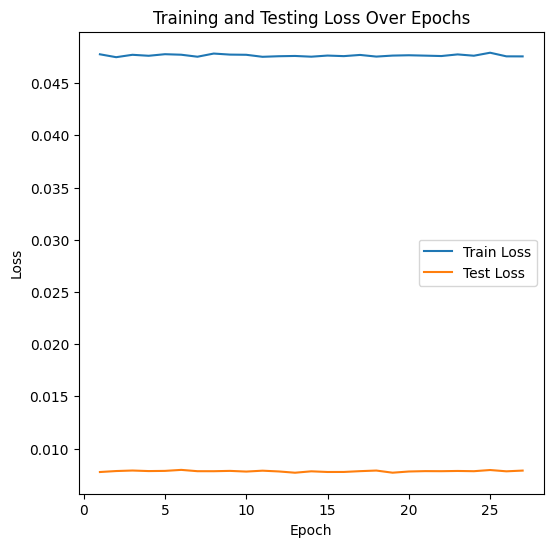

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015501364832744002
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 28/100, Train Loss: 0.04756997188878629, Test Loss: 0.0078266302757045


<Figure size 640x480 with 0 Axes>

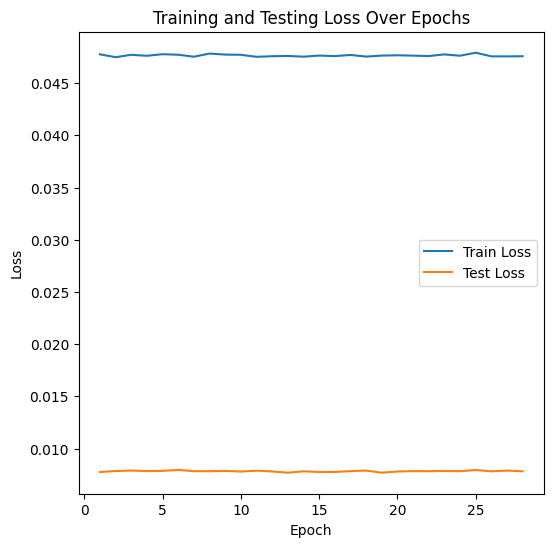

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015521080931648612
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 29/100, Train Loss: 0.0477281419457883, Test Loss: 0.007771867319629281


<Figure size 640x480 with 0 Axes>

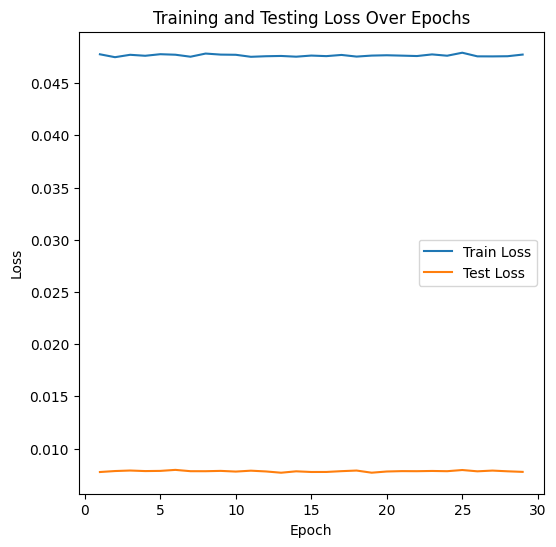

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015517153078690171
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 30/100, Train Loss: 0.0475835451130083, Test Loss: 0.007753156550015024


<Figure size 640x480 with 0 Axes>

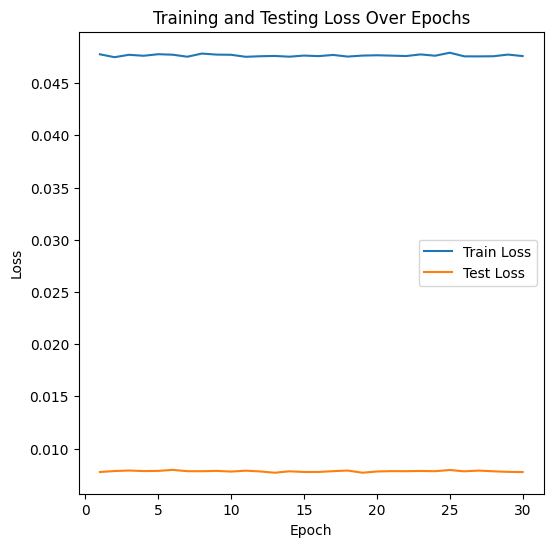

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015521335881203413
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 31/100, Train Loss: 0.04773651253349933, Test Loss: 0.007946520834167848


<Figure size 640x480 with 0 Axes>

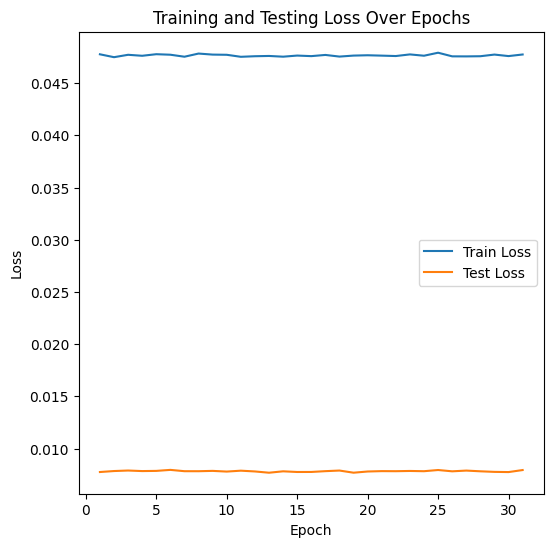

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015528756193816662
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 32/100, Train Loss: 0.047650034472153, Test Loss: 0.00774016170749802


<Figure size 640x480 with 0 Axes>

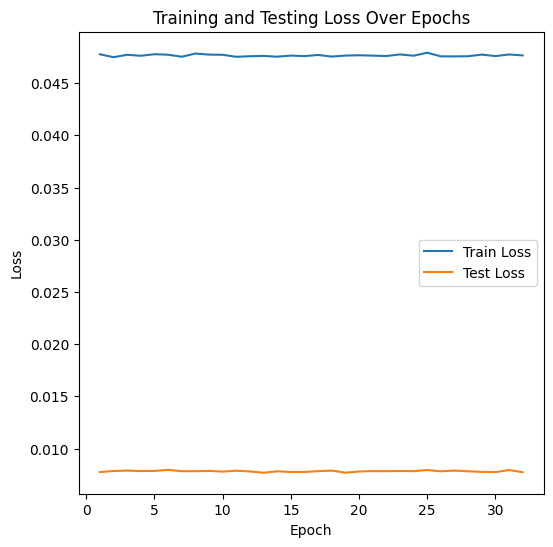

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.001552777481265366
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 33/100, Train Loss: 0.04756327633042094, Test Loss: 0.007848060000723443


<Figure size 640x480 with 0 Axes>

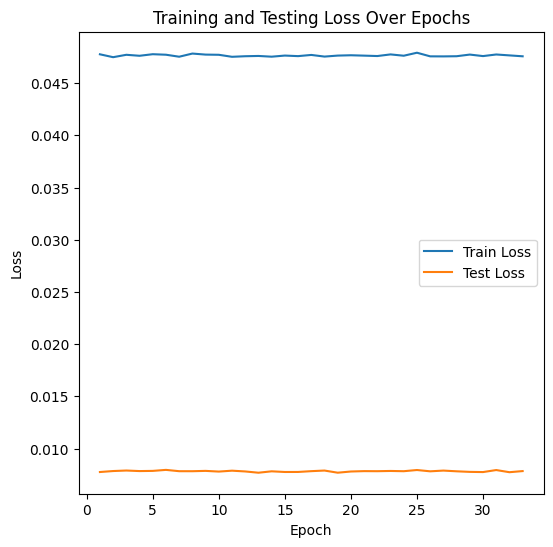

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015501688467338681
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 34/100, Train Loss: 0.04751667504004273, Test Loss: 0.0078237321885228


<Figure size 640x480 with 0 Axes>

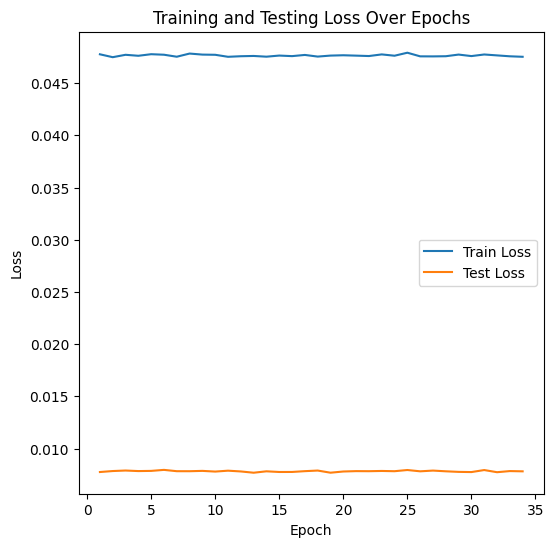

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015534854028373957
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 35/100, Train Loss: 0.04757192755891035, Test Loss: 0.007761410700837111


<Figure size 640x480 with 0 Axes>

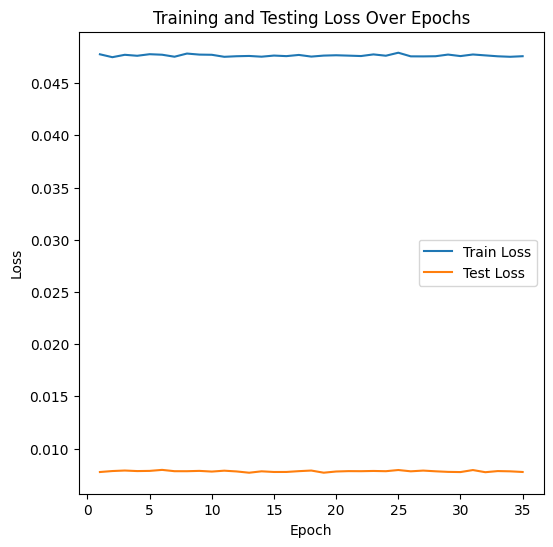

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015533126424998045
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 36/100, Train Loss: 0.04761526246762722, Test Loss: 0.007821652045612313


<Figure size 640x480 with 0 Axes>

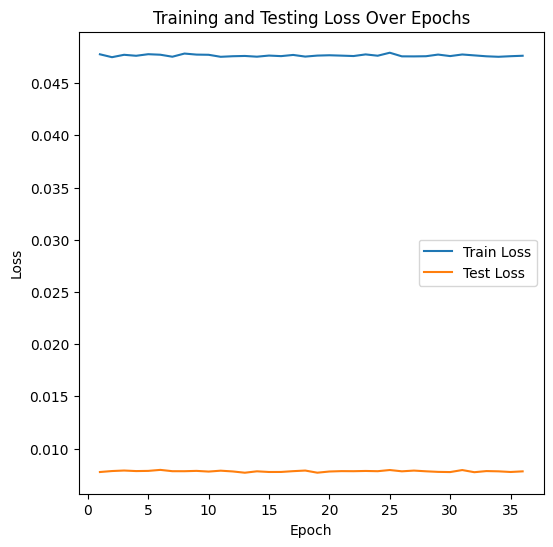

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015537493163719773
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 37/100, Train Loss: 0.047677203599201565, Test Loss: 0.007802356653252855


<Figure size 640x480 with 0 Axes>

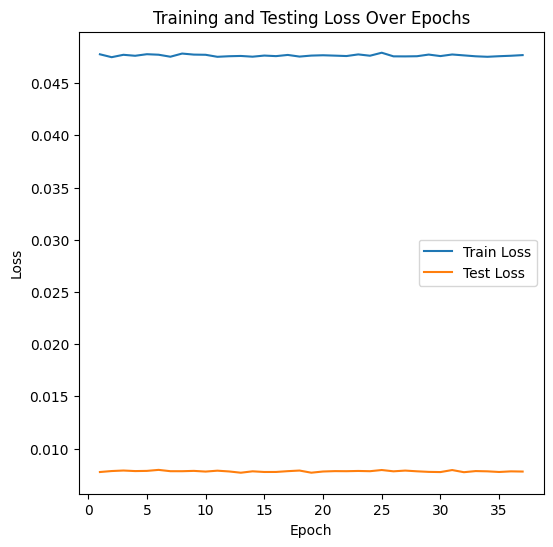

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.001554726855829358
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 38/100, Train Loss: 0.04758985816481191, Test Loss: 0.007800961953642423


<Figure size 640x480 with 0 Axes>

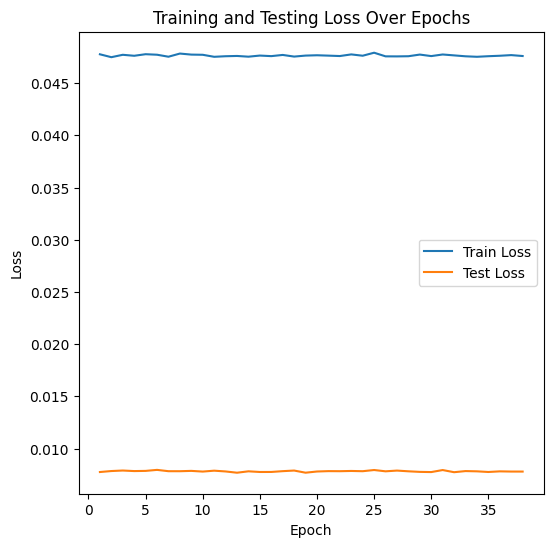

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015539164887741208
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 39/100, Train Loss: 0.047702538674277616, Test Loss: 0.007856886238038287


<Figure size 640x480 with 0 Axes>

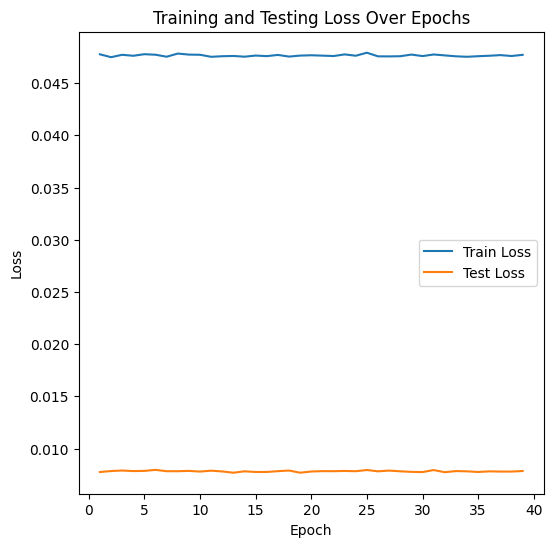

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.001550821354612708
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 40/100, Train Loss: 0.047662645709487604, Test Loss: 0.007843436810584066


<Figure size 640x480 with 0 Axes>

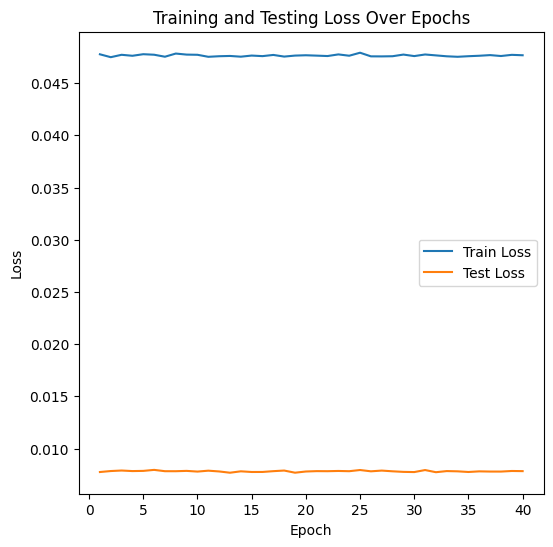

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.001553674228489399
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 41/100, Train Loss: 0.04755565069989681, Test Loss: 0.007734231998243816


<Figure size 640x480 with 0 Axes>

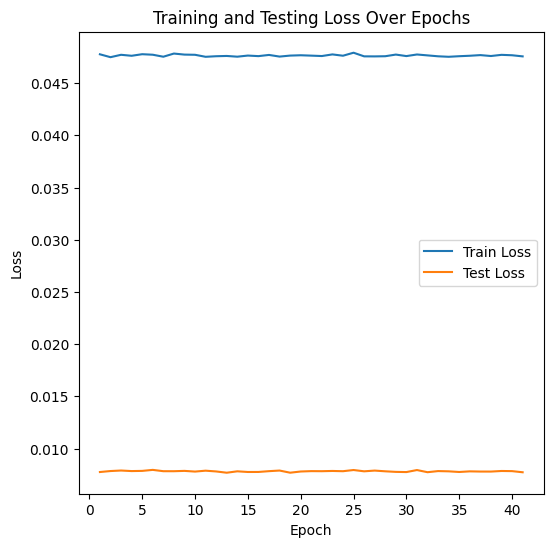

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015533484984189272
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 42/100, Train Loss: 0.04768723807187857, Test Loss: 0.007839244768303255


<Figure size 640x480 with 0 Axes>

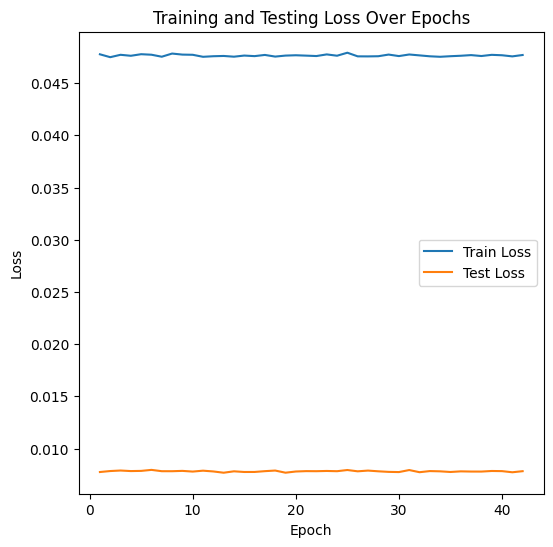

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.001553068170323968
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 43/100, Train Loss: 0.04763100405107464, Test Loss: 0.007819351099500674


<Figure size 640x480 with 0 Axes>

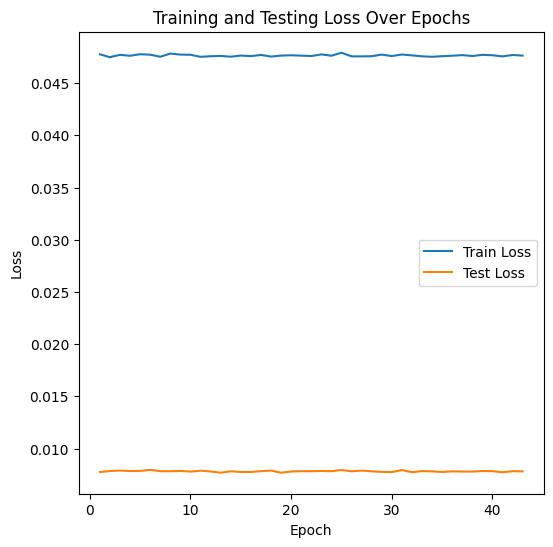

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015538155566900969
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 44/100, Train Loss: 0.04775501395534566, Test Loss: 0.007900305070537893


<Figure size 640x480 with 0 Axes>

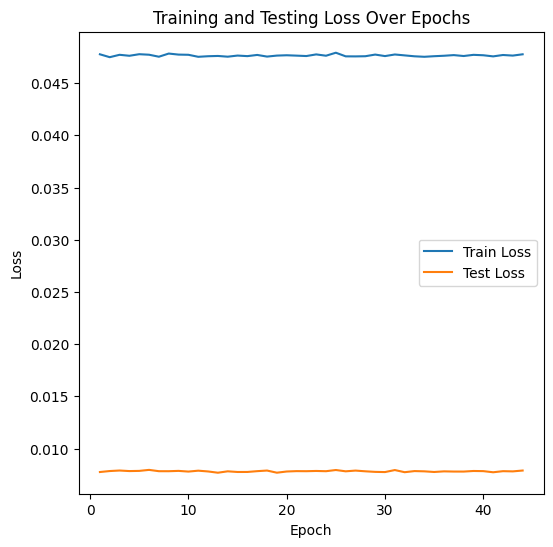

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.001549326116219163
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 45/100, Train Loss: 0.0475146099843179, Test Loss: 0.007898312125964486


<Figure size 640x480 with 0 Axes>

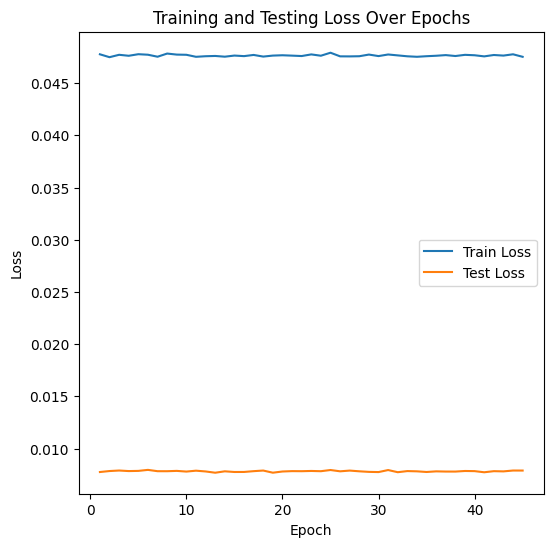

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015564265195280313
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 46/100, Train Loss: 0.04770380265595814, Test Loss: 0.007862590873315957


<Figure size 640x480 with 0 Axes>

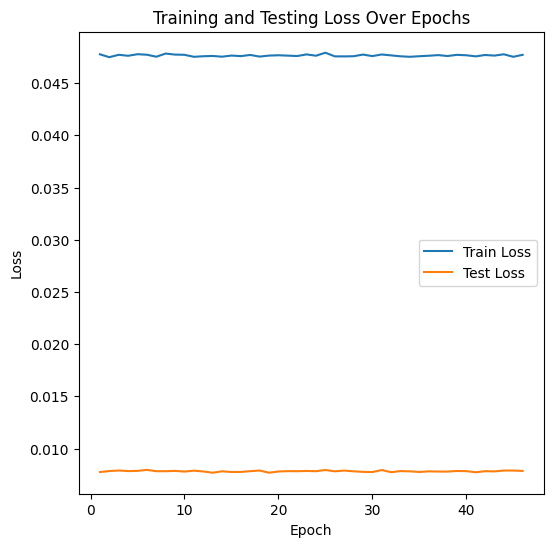

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015560926403850317
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 47/100, Train Loss: 0.0476430753510035, Test Loss: 0.007851199446275913


<Figure size 640x480 with 0 Axes>

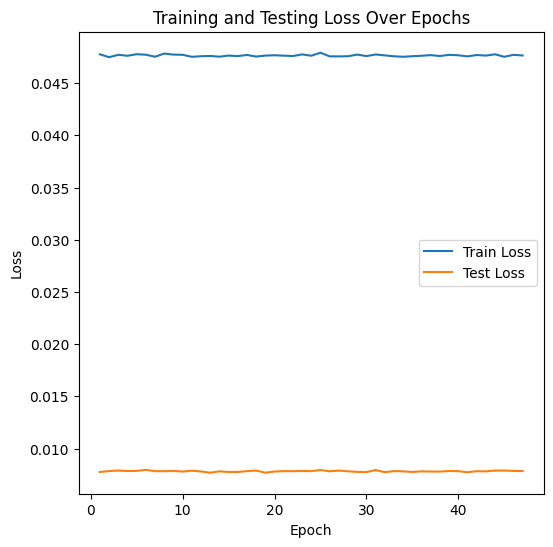

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015528692165389657
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 48/100, Train Loss: 0.04762862541206899, Test Loss: 0.007823878543944925


<Figure size 640x480 with 0 Axes>

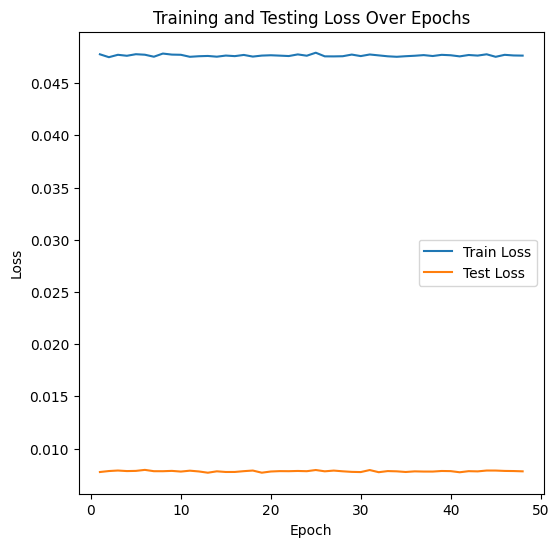

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.001553304959088564
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 49/100, Train Loss: 0.04771981567062447, Test Loss: 0.007837762338883114


<Figure size 640x480 with 0 Axes>

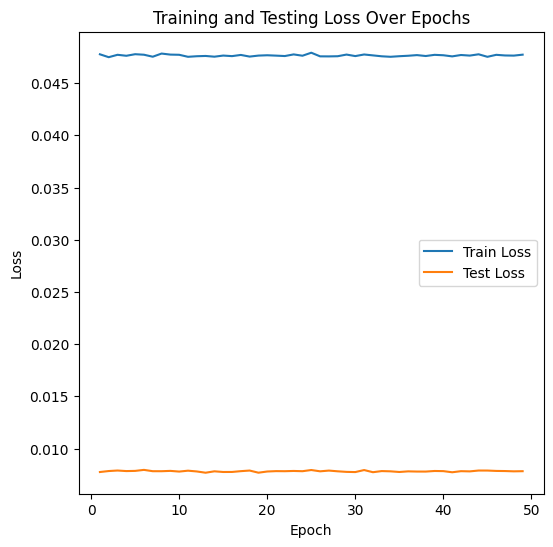

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.001552649773657322
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 50/100, Train Loss: 0.047750633050308855, Test Loss: 0.007927702235777481


<Figure size 640x480 with 0 Axes>

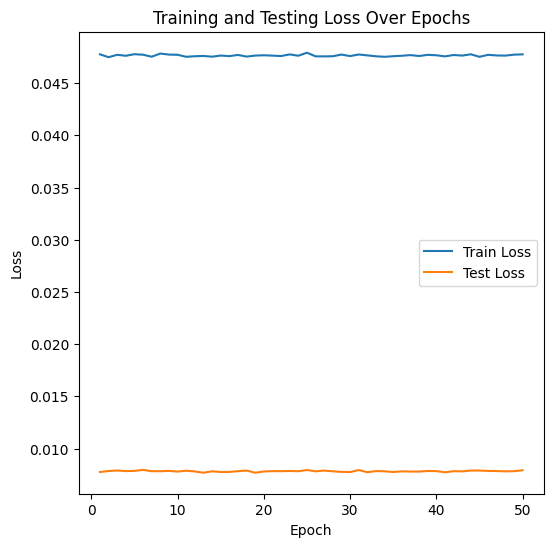

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015536179998889565
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 51/100, Train Loss: 0.04766656287394512, Test Loss: 0.007810059831450945


<Figure size 640x480 with 0 Axes>

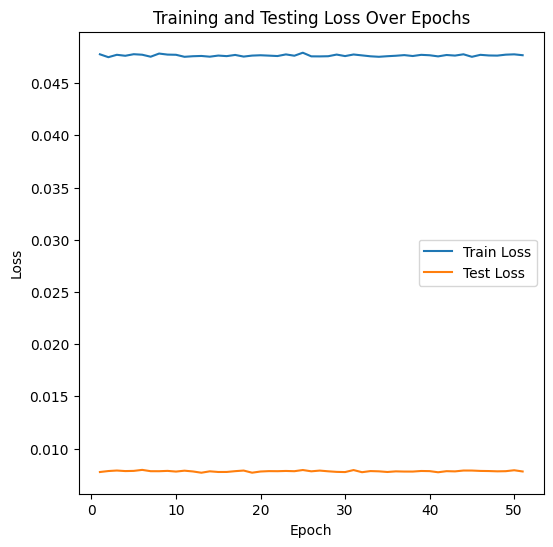

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015534983249381185
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 52/100, Train Loss: 0.04769467957974041, Test Loss: 0.007910831972029974


<Figure size 640x480 with 0 Axes>

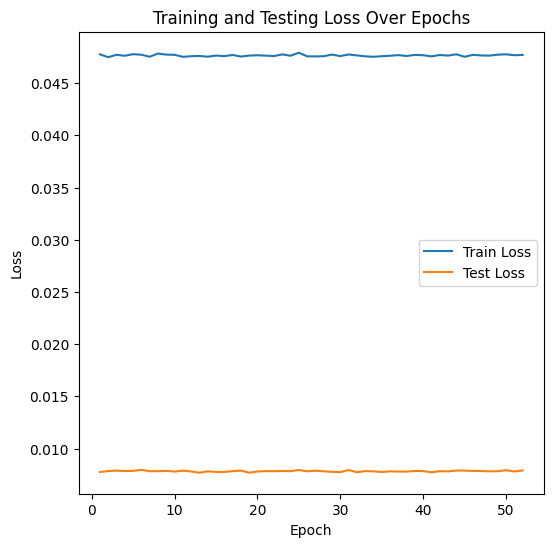

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015511780511587858
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 53/100, Train Loss: 0.04757371417081989, Test Loss: 0.007897610026461343


<Figure size 640x480 with 0 Axes>

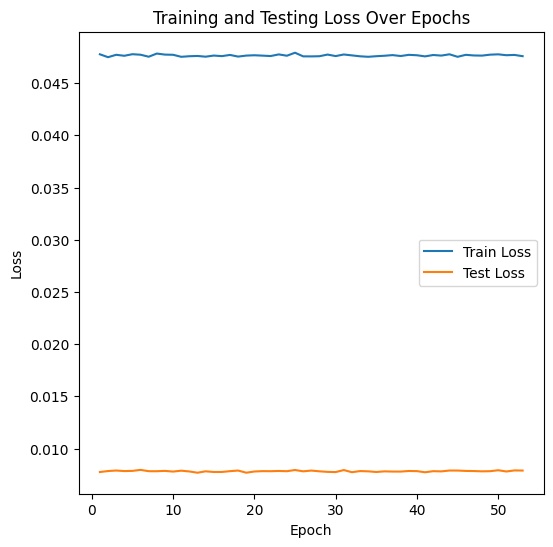

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015540001913905144
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 54/100, Train Loss: 0.04777992808883504, Test Loss: 0.007856917546779255


<Figure size 640x480 with 0 Axes>

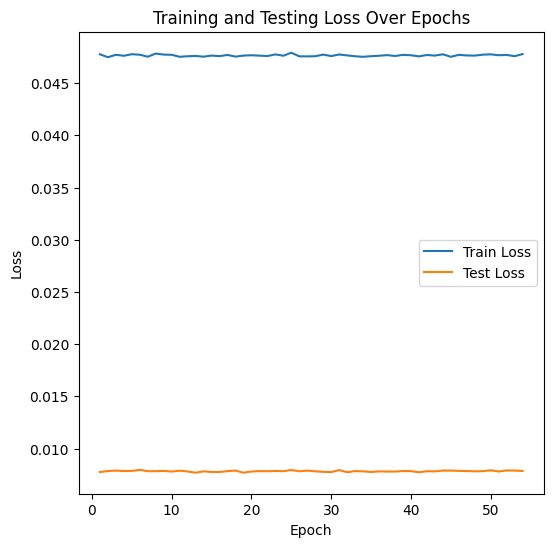

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.001553477137349546
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 55/100, Train Loss: 0.04756283819637418, Test Loss: 0.007787837686411609


<Figure size 640x480 with 0 Axes>

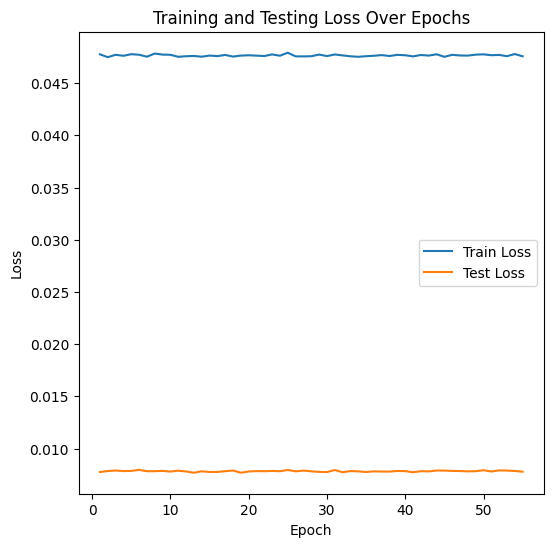

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015527911018580198
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 56/100, Train Loss: 0.047664095506616704, Test Loss: 0.007909022945603956


<Figure size 640x480 with 0 Axes>

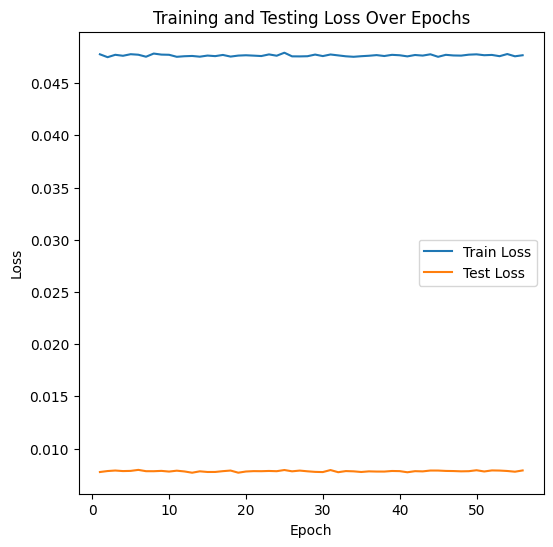

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015492598759010434
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 57/100, Train Loss: 0.04750590491575868, Test Loss: 0.007793074721388261


<Figure size 640x480 with 0 Axes>

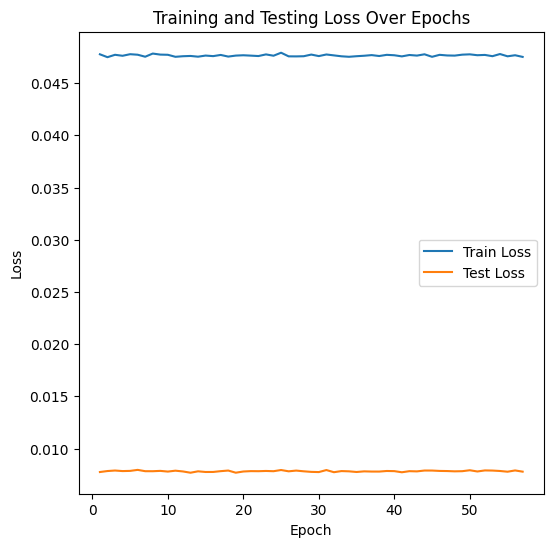

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015519720036536455
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 58/100, Train Loss: 0.04771350799793341, Test Loss: 0.007829340721004854


<Figure size 640x480 with 0 Axes>

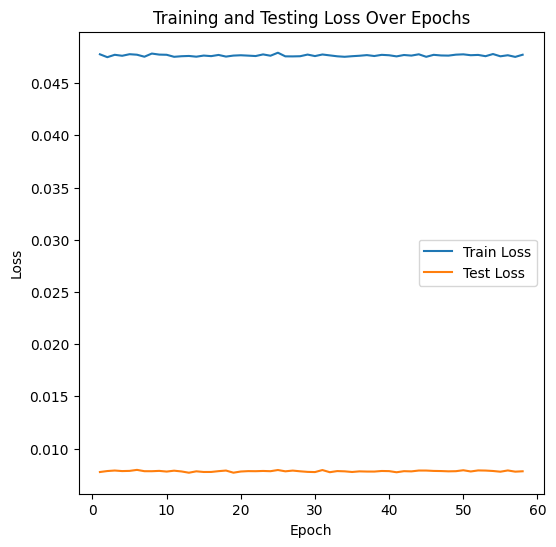

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015530308010056615
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 59/100, Train Loss: 0.047737338225223996, Test Loss: 0.007805762433584398


<Figure size 640x480 with 0 Axes>

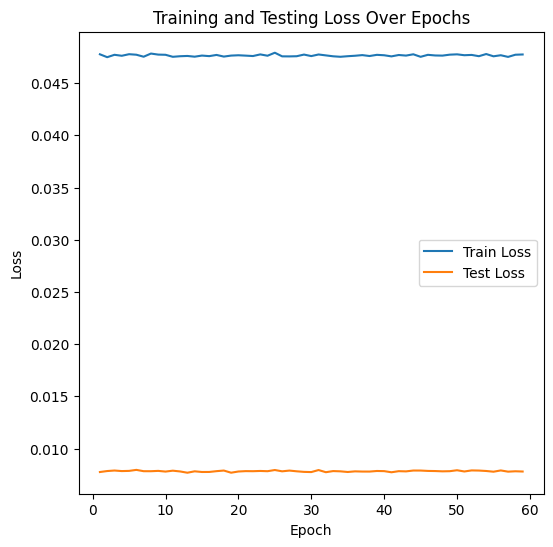

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015512823592871428
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 60/100, Train Loss: 0.04767582789039156, Test Loss: 0.007776828808707282


<Figure size 640x480 with 0 Axes>

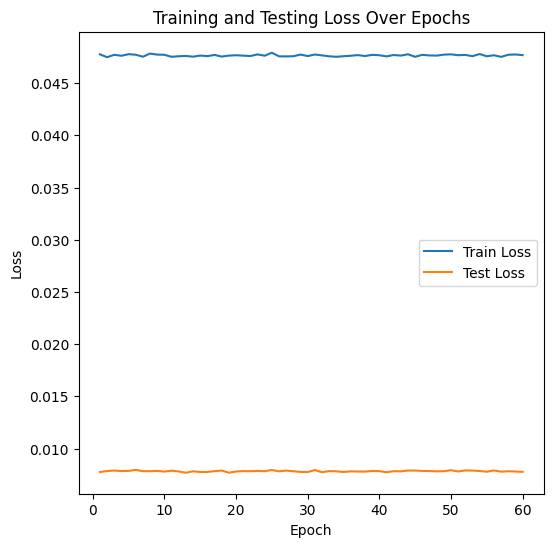

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015528547810390592
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 61/100, Train Loss: 0.0475686654282129, Test Loss: 0.00796152233287793


<Figure size 640x480 with 0 Axes>

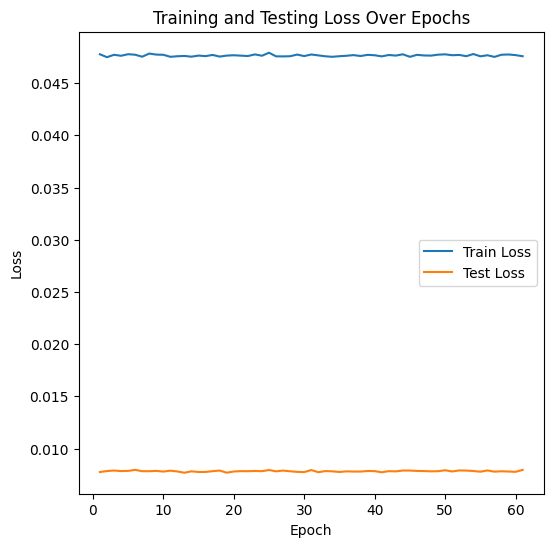

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015551832038909197
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 62/100, Train Loss: 0.04774986047819911, Test Loss: 0.007831192749993814


<Figure size 640x480 with 0 Axes>

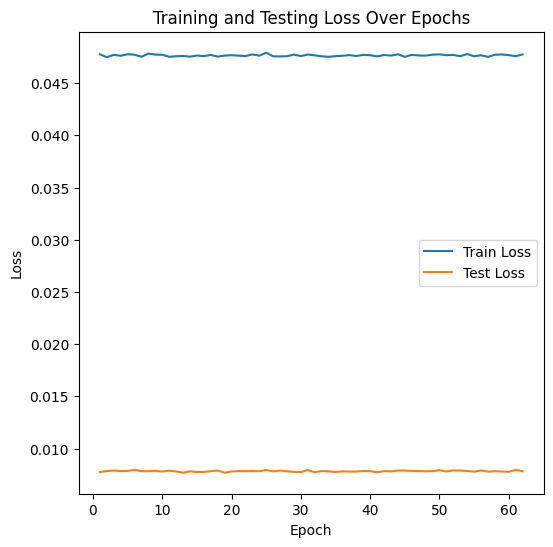

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.001551461173221469
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 63/100, Train Loss: 0.04768268952040847, Test Loss: 0.007887481175272111


<Figure size 640x480 with 0 Axes>

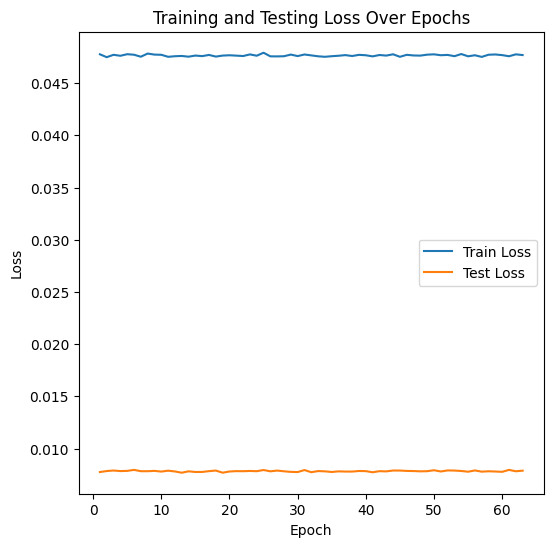

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015520215965807438
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 64/100, Train Loss: 0.04760843545416749, Test Loss: 0.007859863773959561


<Figure size 640x480 with 0 Axes>

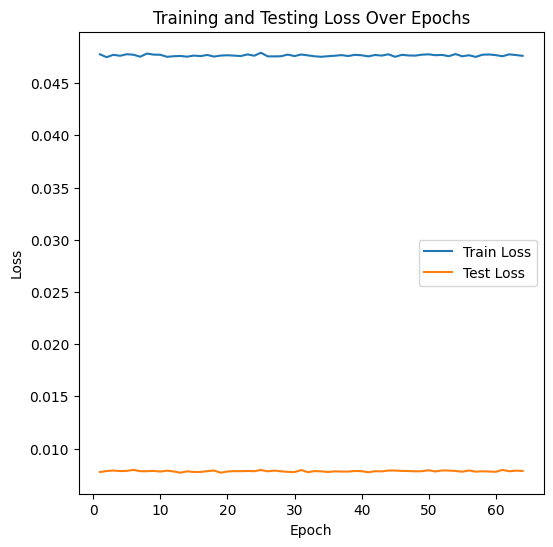

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.001551618566736579
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 65/100, Train Loss: 0.047616846843467606, Test Loss: 0.007830355925568784


<Figure size 640x480 with 0 Axes>

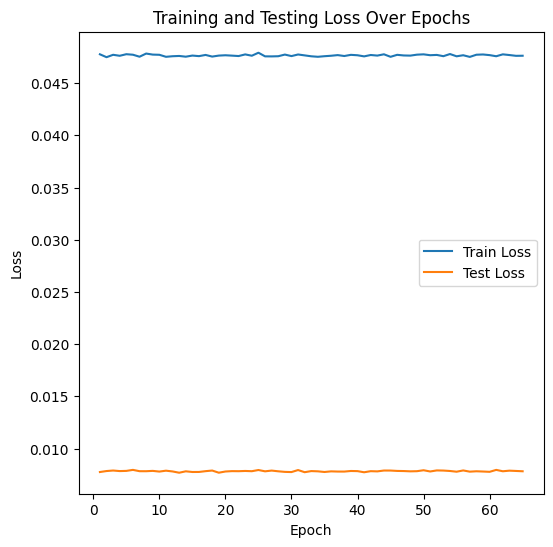

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015524227637797594
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 66/100, Train Loss: 0.04757698530115206, Test Loss: 0.00781381026150329


<Figure size 640x480 with 0 Axes>

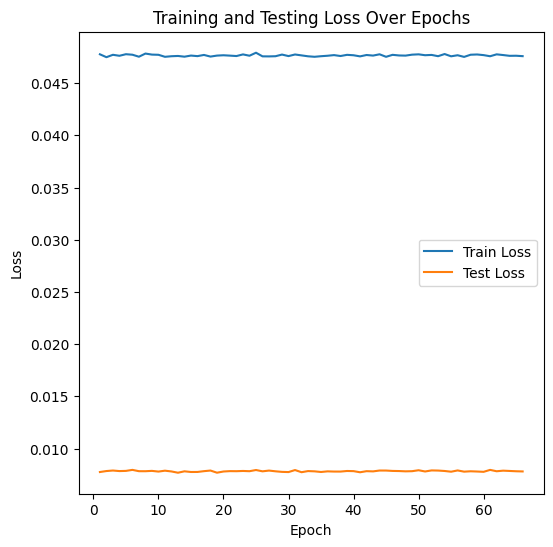

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015530375530943274
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 67/100, Train Loss: 0.0477419085781118, Test Loss: 0.007834496879471126


<Figure size 640x480 with 0 Axes>

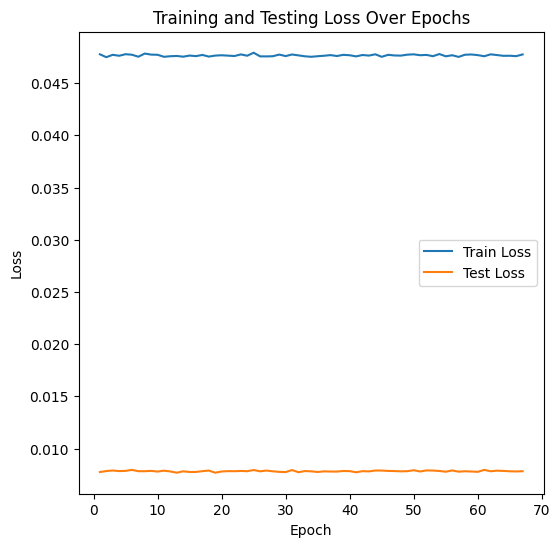

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.001551318448036909
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 68/100, Train Loss: 0.0476770459200868, Test Loss: 0.007799111926959235


<Figure size 640x480 with 0 Axes>

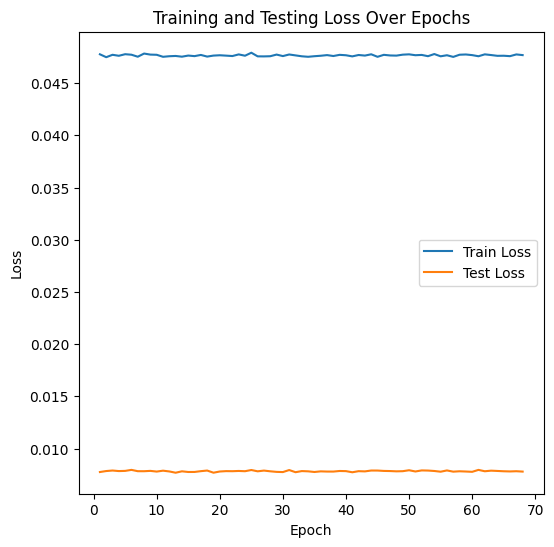

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015539329033344984
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 69/100, Train Loss: 0.047560755287206324, Test Loss: 0.007786850253100321


<Figure size 640x480 with 0 Axes>

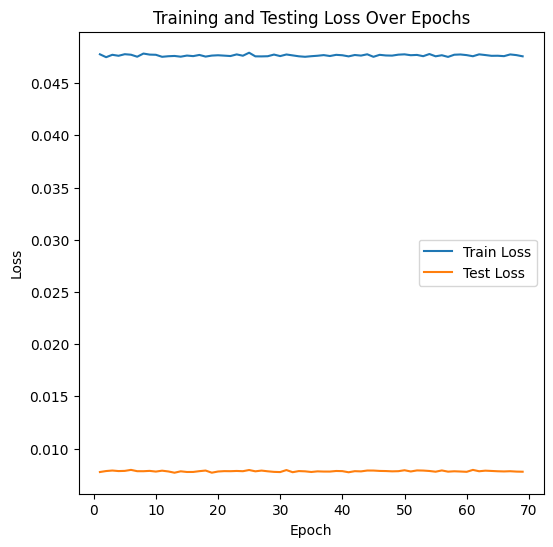

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015519288135692477
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 70/100, Train Loss: 0.04768172054563521, Test Loss: 0.007822302795854458


<Figure size 640x480 with 0 Axes>

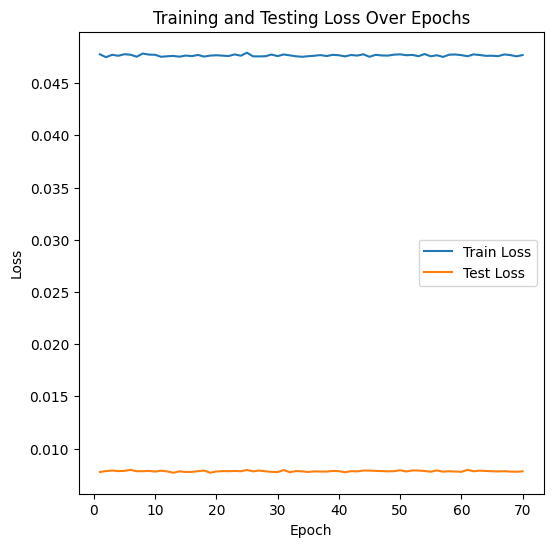

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015511376550421119
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 71/100, Train Loss: 0.04770657706616219, Test Loss: 0.007854176910675671


<Figure size 640x480 with 0 Axes>

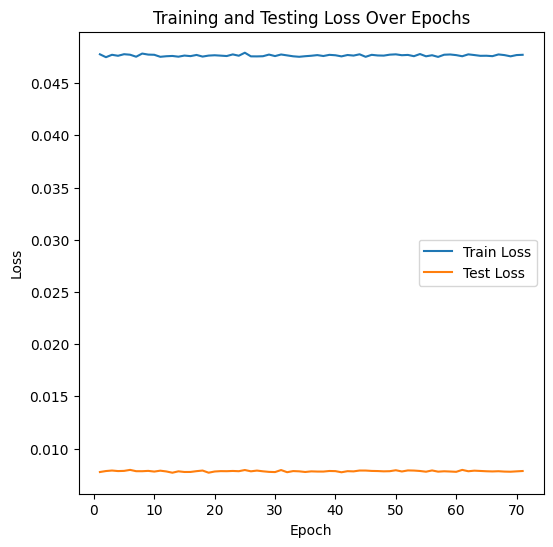

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015512099489569664
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 72/100, Train Loss: 0.047645512462521626, Test Loss: 0.007800406489257577


<Figure size 640x480 with 0 Axes>

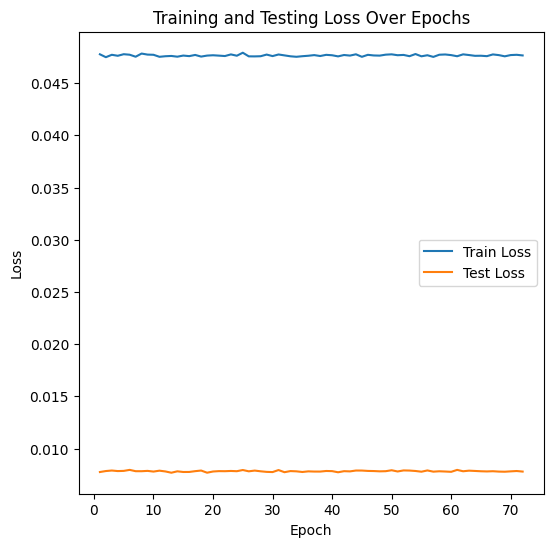

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015526378992944956
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 73/100, Train Loss: 0.0477004579153817, Test Loss: 0.007812877157178148


<Figure size 640x480 with 0 Axes>

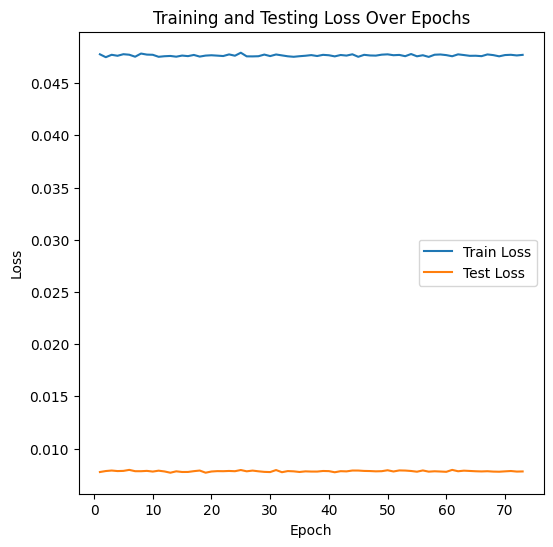

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015507953939959407
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 74/100, Train Loss: 0.04769778606430741, Test Loss: 0.007801470408824413


<Figure size 640x480 with 0 Axes>

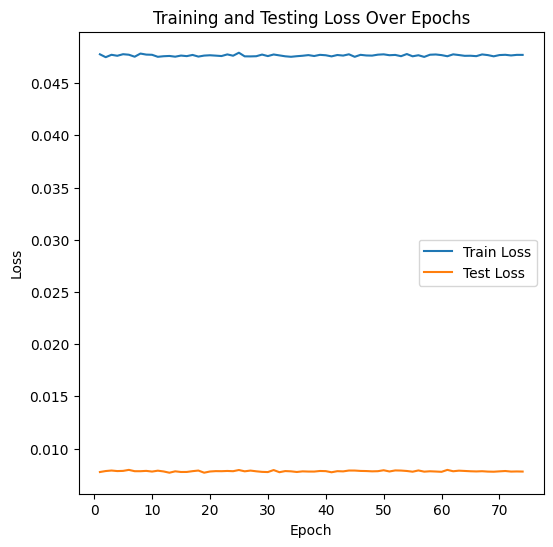

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015513828257098794
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 75/100, Train Loss: 0.04770717411078551, Test Loss: 0.00792390124048195


<Figure size 640x480 with 0 Axes>

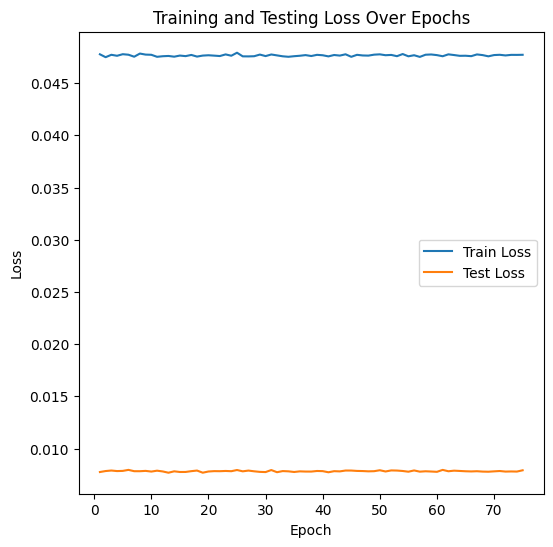

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015548355877399445
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 76/100, Train Loss: 0.04767305740258289, Test Loss: 0.007757178153633378


<Figure size 640x480 with 0 Axes>

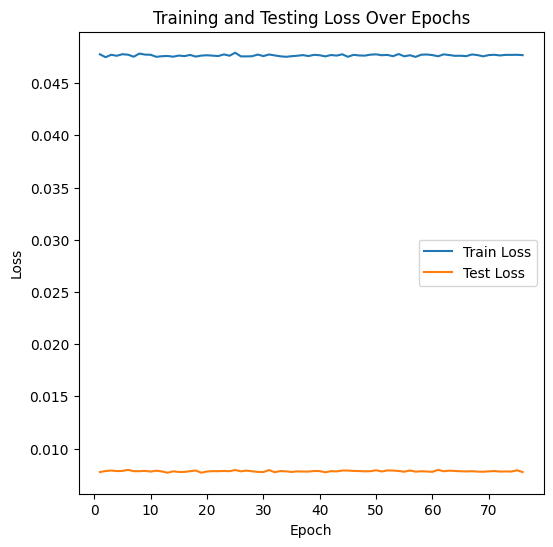

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015541278989985585
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 77/100, Train Loss: 0.04764267939490165, Test Loss: 0.007847412378487628


<Figure size 640x480 with 0 Axes>

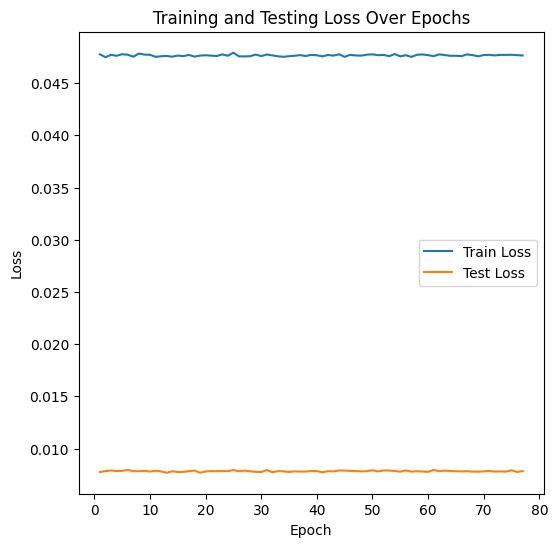

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015528510557487607
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 78/100, Train Loss: 0.04782234591065986, Test Loss: 0.007859357481850316


<Figure size 640x480 with 0 Axes>

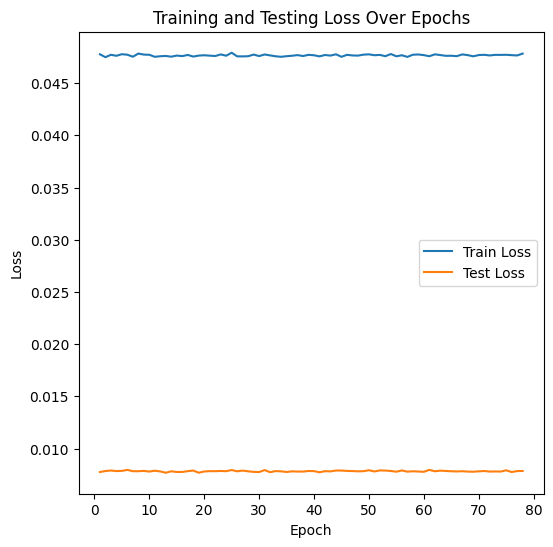

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015509560471400619
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 79/100, Train Loss: 0.047530230064206785, Test Loss: 0.007898899407220522


<Figure size 640x480 with 0 Axes>

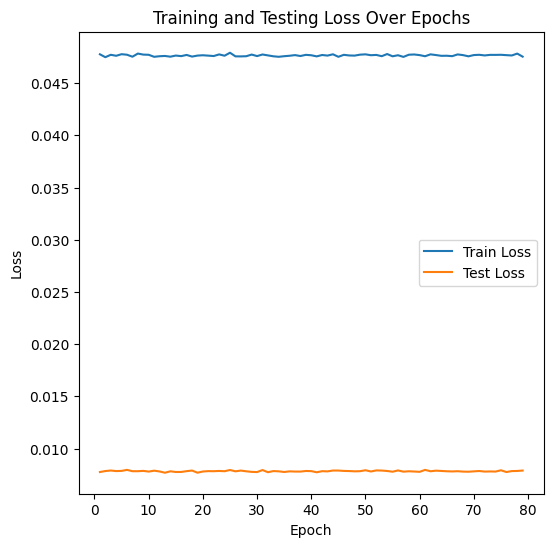

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015538836596533656
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 80/100, Train Loss: 0.04761420043076213, Test Loss: 0.007834771204670434


<Figure size 640x480 with 0 Axes>

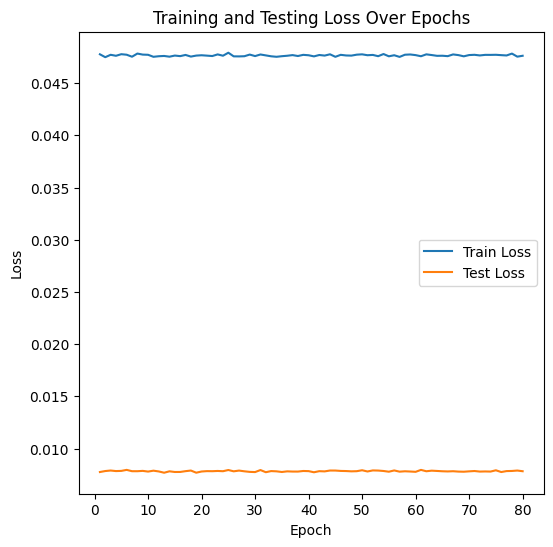

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015524700284004211
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 81/100, Train Loss: 0.047750948577701534, Test Loss: 0.00786848685873454


<Figure size 640x480 with 0 Axes>

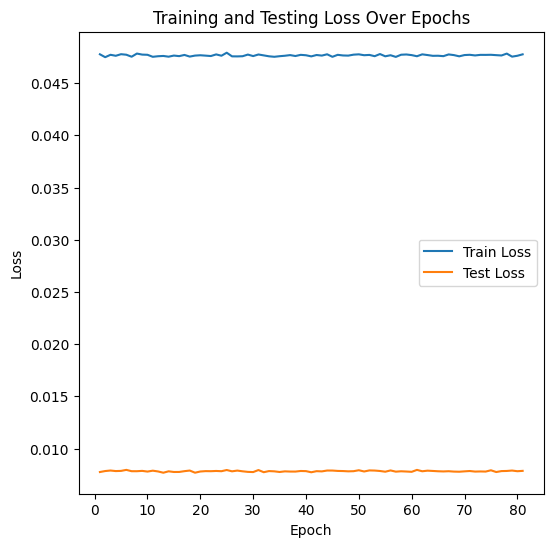

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.001551806926727295
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 82/100, Train Loss: 0.04776832677385869, Test Loss: 0.007836118409332652


<Figure size 640x480 with 0 Axes>

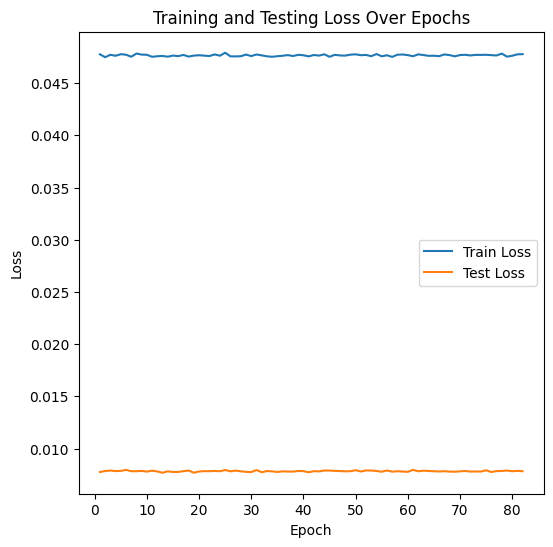

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015547361690551043
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 83/100, Train Loss: 0.04772357020195918, Test Loss: 0.007891045719493794


<Figure size 640x480 with 0 Axes>

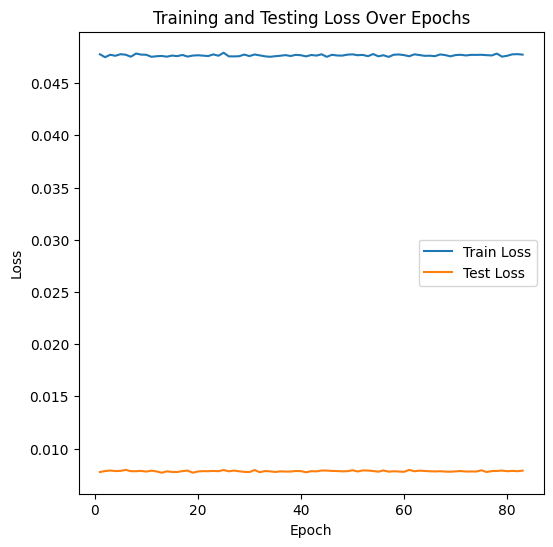

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.001552401576191187
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 84/100, Train Loss: 0.047736539227076345, Test Loss: 0.007829651164688926


<Figure size 640x480 with 0 Axes>

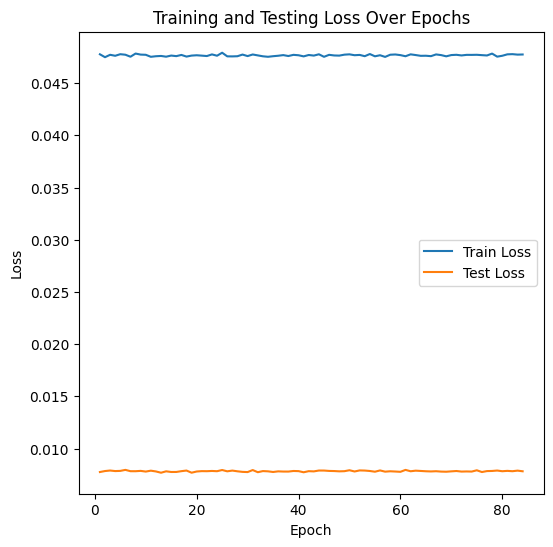

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015512467361986637
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 85/100, Train Loss: 0.04761711437498513, Test Loss: 0.00784290705181087


<Figure size 640x480 with 0 Axes>

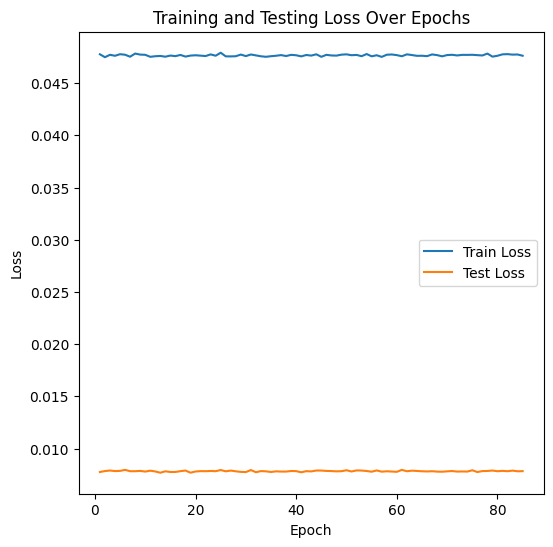

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.001550215412862599
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 86/100, Train Loss: 0.04770462637447064, Test Loss: 0.007828357905958972


<Figure size 640x480 with 0 Axes>

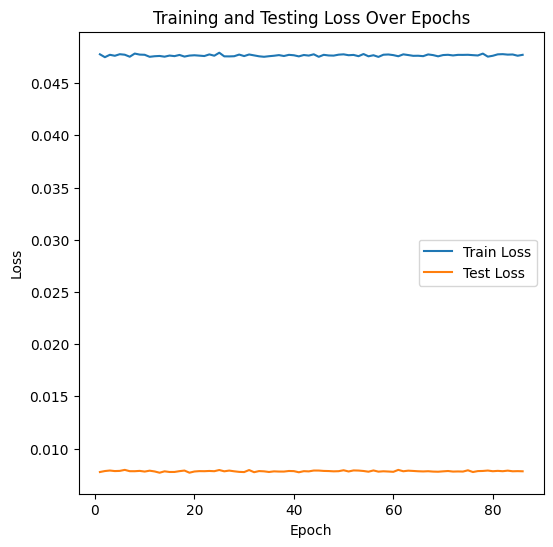

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015515914419665933
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 87/100, Train Loss: 0.04768859971303904, Test Loss: 0.007832604795821664


<Figure size 640x480 with 0 Axes>

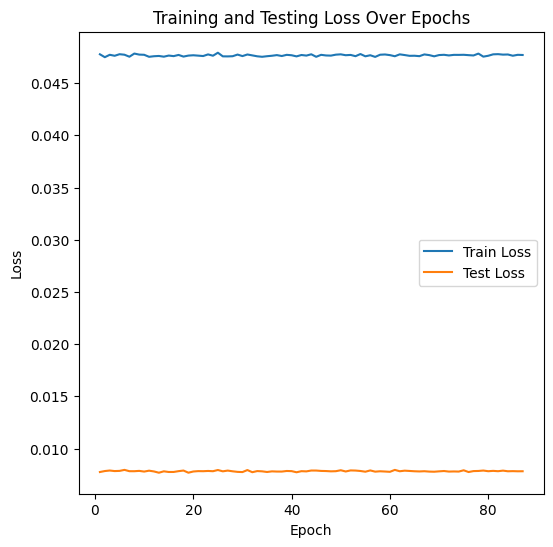

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015525557100772858
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 88/100, Train Loss: 0.04770760756336761, Test Loss: 0.0078078901332921105


<Figure size 640x480 with 0 Axes>

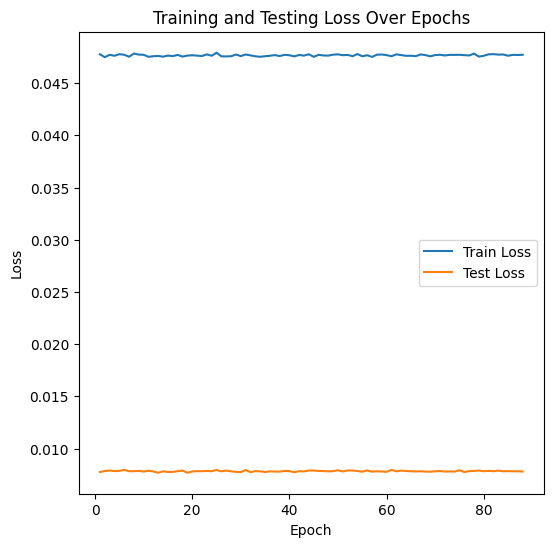

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015502622118219733
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 89/100, Train Loss: 0.0475745633344077, Test Loss: 0.007785927900331647


<Figure size 640x480 with 0 Axes>

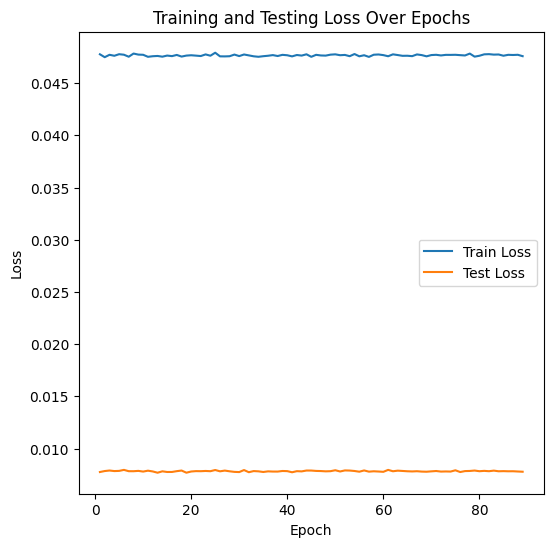

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.001554708112962544
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 90/100, Train Loss: 0.047612887337559626, Test Loss: 0.007855786851969132


<Figure size 640x480 with 0 Axes>

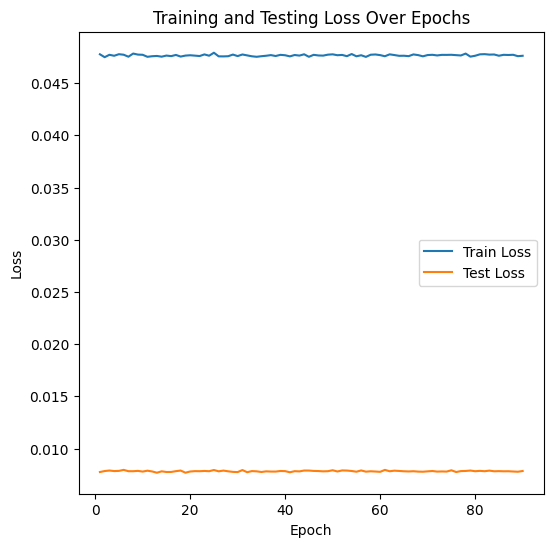

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015554295387119055
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 91/100, Train Loss: 0.0476103566003256, Test Loss: 0.008272728113126548


<Figure size 640x480 with 0 Axes>

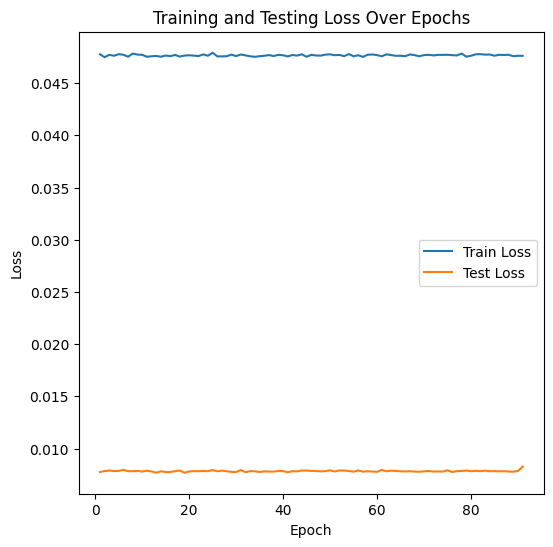

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015547662042081356
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 92/100, Train Loss: 0.047659570080271205, Test Loss: 0.00792308651739248


<Figure size 640x480 with 0 Axes>

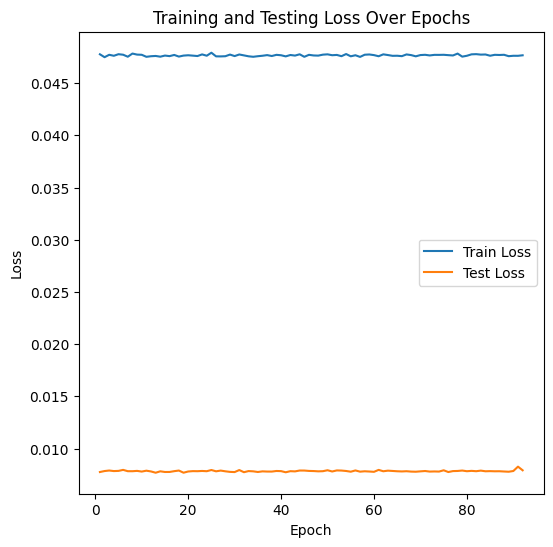

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015543795889243484
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 93/100, Train Loss: 0.047605751204261054, Test Loss: 0.007849400828531413


<Figure size 640x480 with 0 Axes>

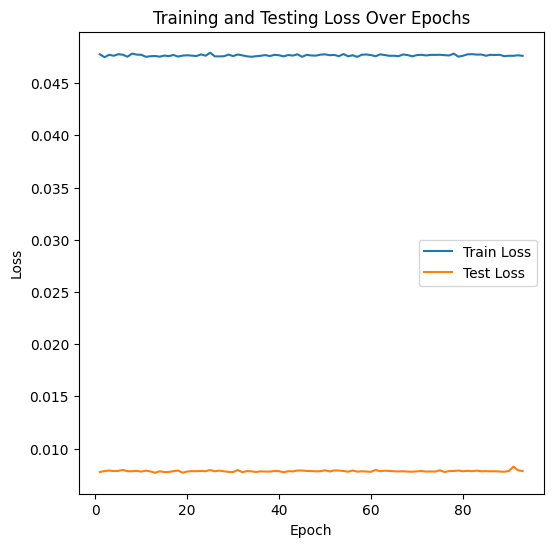

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015526222996413708
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 94/100, Train Loss: 0.04776029207222244, Test Loss: 0.00787879822616743


<Figure size 640x480 with 0 Axes>

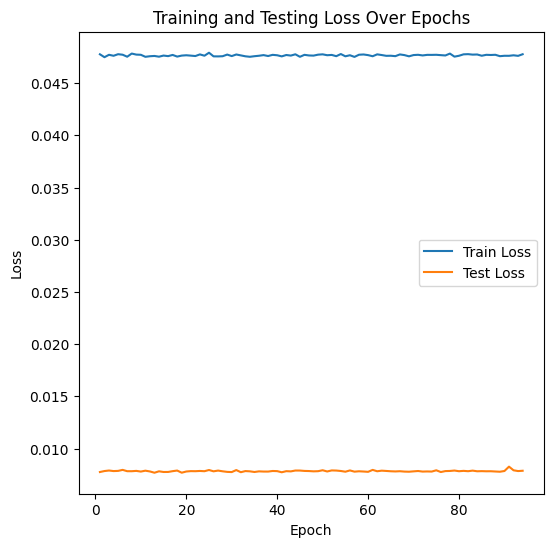

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015503637259826064
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 95/100, Train Loss: 0.04755076330466677, Test Loss: 0.007760113122177591


<Figure size 640x480 with 0 Axes>

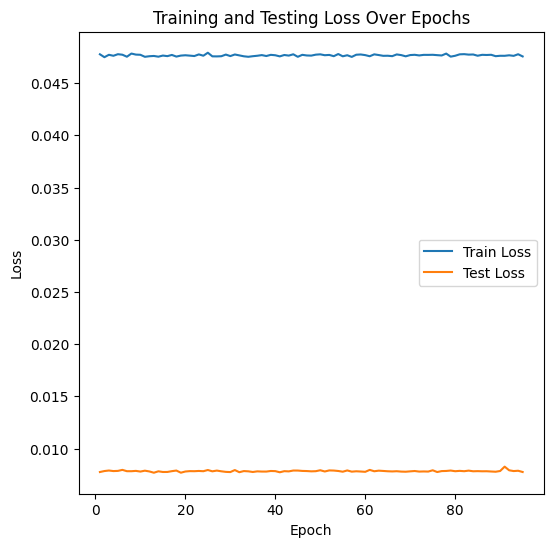

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015540433814749122
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 96/100, Train Loss: 0.04759474162566742, Test Loss: 0.007714101910133448


<Figure size 640x480 with 0 Axes>

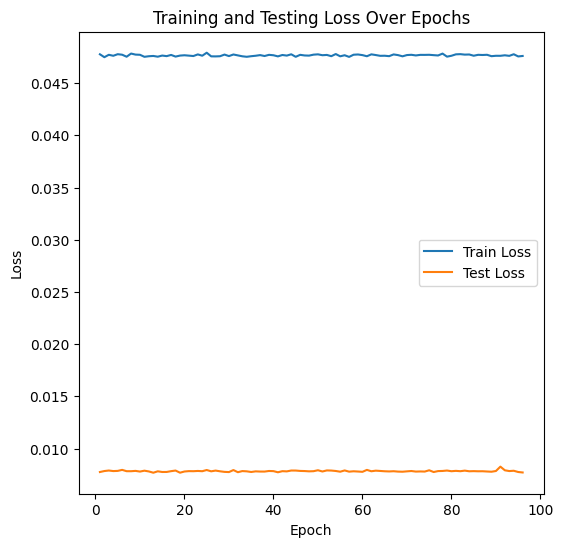

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015552400145679712
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 97/100, Train Loss: 0.04761209963198425, Test Loss: 0.007831877571534631


<Figure size 640x480 with 0 Axes>

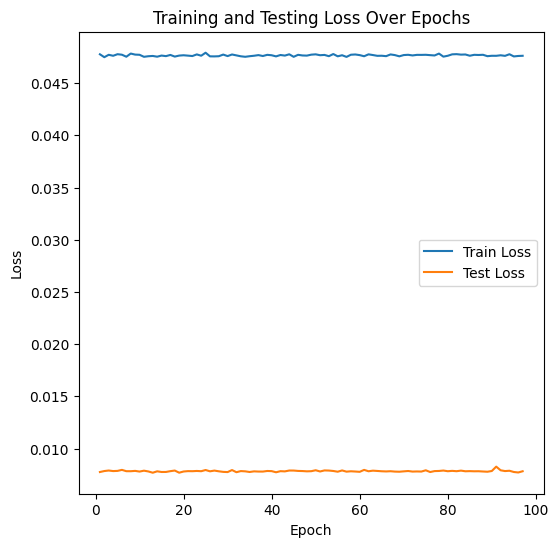

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015560539904981852
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 98/100, Train Loss: 0.04765232480883036, Test Loss: 0.007787347779669898


<Figure size 640x480 with 0 Axes>

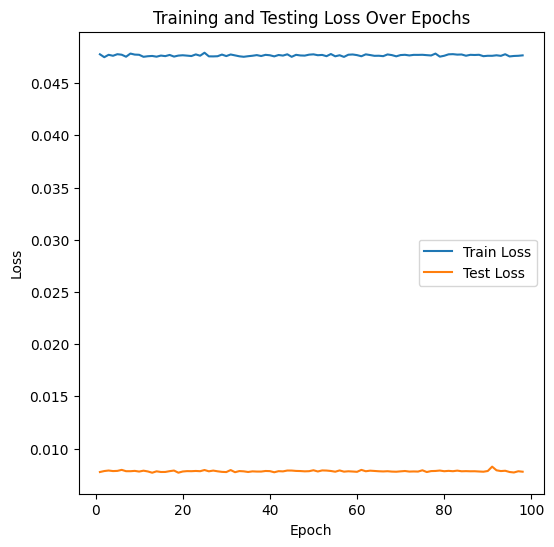

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015550022944808006
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 99/100, Train Loss: 0.047566287134752104, Test Loss: 0.007803503838714093


<Figure size 640x480 with 0 Axes>

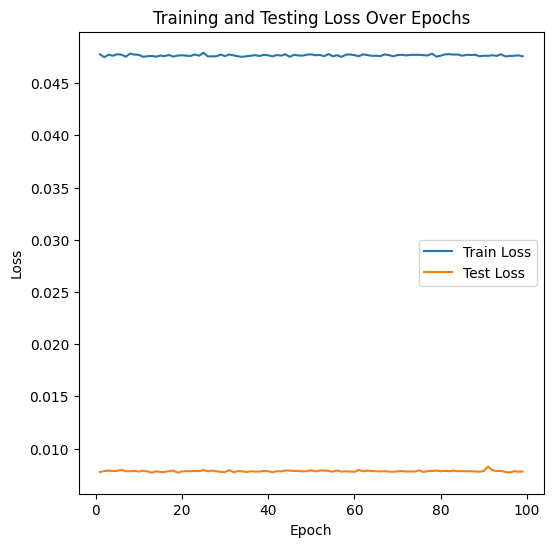

Inside training loop. Batch indices: 0, loss value: inf
Inside training loop. Batch indices: 100000, loss value: 0.0015527281211689115
Inside testing loop. Batch indices: 0, loss value: inf
Epoch 100/100, Train Loss: 0.047597689078884564, Test Loss: 0.007769382289014485


<Figure size 640x480 with 0 Axes>

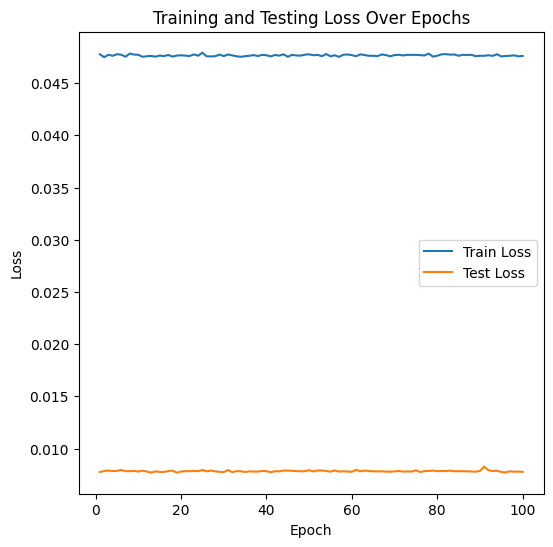

<Figure size 640x480 with 0 Axes>

In [33]:
def create_model_filename(input_size, target_size, d_model, n_heads, num_encoder_layers, lstm_hidden_size, num_lstm_layers):
    return f"model_input{input_size}_target{target_size}_dmodel{d_model}_nheads{n_heads}_encoderlayers{num_encoder_layers}_lstmhidden{lstm_hidden_size}_lstmlayers{num_lstm_layers}.pth"

# 모델 파일 경로
model_file_path = f"model/final v2/{create_model_filename(input_size, target_size, d_model, n_heads, num_encoder_layers, lstm_hidden_size, num_lstm_layers)}"

# 모델 파일이 존재하는지 확인하고, 존재할 경우 모델 로드
if os.path.isfile(model_file_path):
    model.load_state_dict(torch.load(model_file_path))
    print("Pre-trained model loaded.")
else:
    print("No pre-trained model found. Initializing a new model.")

# 학습 과정
train_losses = []
test_losses = []
best_test_loss = float('inf')

# Define the directory for saving figures
figures_directory = "figures/final v2"
model_name = create_model_filename(input_size, target_size, d_model, n_heads, num_encoder_layers, lstm_hidden_size, num_lstm_layers).replace('.pth', '')  # Use the generated model name without the file extension
model_figures_directory = os.path.join(figures_directory, model_name)

# Create the directories if they do not exist
os.makedirs(model_figures_directory, exist_ok=True)

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    test_loss = test(model, test_loader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # Update best test loss and save model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), model_file_path)
        print(f"Model saved as '{create_model_filename(input_size, target_size, d_model, n_heads, num_encoder_layers, lstm_hidden_size, num_lstm_layers)}' at Epoch {epoch + 1}")

    # Print epoch results
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Test Loss: {test_loss}")


    # Plotting
    plt.figure(figsize=(6, 6))

    # 학습 과정 시각화
    plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
    plt.plot(range(1, epoch + 2), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Over Epochs')
    plt.legend()

    # Save the figure before calling show
    figure_path = os.path.join(model_figures_directory, f"Epoch_{epoch+1}.png")
    plt.savefig(figure_path)

    # Then display the plot
    plt.show()

    # Clear the figure after displaying it to prepare for the next plot if this is not the last epoch
    plt.clf()




    # # Plot training loss
    # plt.subplot(1, 2, 1)
    # plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Training Loss Over Epochs')
    # plt.legend()

    # # Plot testing loss
    # plt.subplot(1, 2, 2)
    # plt.plot(range(1, epoch + 2), test_losses, label='Test Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Testing Loss Over Epochs')
    # plt.legend()

    # plt.tight_layout()
    # plt.show()